# **1. Introdcution, packages and functions**

In [2]:
# Python Script for Multiplexed FISH data analysis from Bintu et al 2018
# Related publication : Chromatin structure from high resolution microscopy: scaling laws and microphase separation
# Authors: Loucif Remini, Midas Segers, John Palmeri, Jean-Charles Walter, Andrea Parmeggiani, Enrico Carlon
# Date: November 18, 2023
# Description: This script analyzes data from a CSV file and generates :

# * Evidence of two coexisting chromatin phases contribution into the pairwise probability distance distributions
# * The scaling behaviour of the effective chromatin and for the distinct phases
# * A summary of the phases radii for any pair of tags (i,j) displayed as heatmaps
# * Single cell analysis and fit
# * Beta phase position's prediction in single cells


In [3]:
# Import necessary libraries and modules for data analysis
import glob  # For file path matching
import os  # For interacting with the operating system
import numpy as np  # For numerical operations and array handling
import matplotlib.pyplot as plt  # For data visualization
import math  # For mathematical functions
from scipy.optimize import curve_fit  # For fitting curves to data
from scipy.spatial.distance import pdist, squareform  # For distance calculations and transforming data
from scipy.signal import argrelextrema  # For finding relative extrema in data
from scipy.ndimage import gaussian_filter  # For applying a Gaussian filter to data
from matplotlib.lines import Line2D  # Import Line2D
from fractions import Fraction
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec


# Get the default color cycle for plotting
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']


In [4]:
################################################################################
# Read Bintu Data
################################################################################

def READ_BINTU_CSV(filename, dir):
    """
    Read Bintu data from a CSV file.

    Parameters:
    - filename (str): The name of the CSV file.
    - dir (str): The directory containing the file.

    Returns:
    - numpy.ndarray: Numpy array containing Bintu data in micrometers.
    """
    file = f'{dir}/{filename}'
    lines = [ln[:-1].split(',') for ln in open(file, 'r')]
    keep = np.array(list(map(len, lines))) > 1
    data = np.array([line for line, kp in zip(lines, keep) if kp][1:], dtype=float)
    nchr = len(np.unique(data[:, 0]))
    chrZXY = data[:, 2:].reshape(nchr, -1, 3)
    return chrZXY / 1000

def NonNanPaths(zxys):
    """
    Filter out paths with NaN values.

    Parameters:
    - zxys (numpy.ndarray): 3D array containing Bintu data for multiple cells.

    Returns:
    - numpy.ndarray: Filtered cells containing non-NaN values.
    - list: List of zxys arrays for non-NaN cells.
    """
    cells = np.array([c for c in range(len(zxys)) if not True in np.isnan(zxys[c])], dtype=int)
    zxys_ = []
    for c in cells:
        zxys_.append(zxys[c])
    return cells, zxys_

################################################################################
# Fitting Model
################################################################################

def GAUSSIAN_DISTR(r, R):
    """
    Calculate the Gaussian distribution.

    Parameters:
    - r (float): The distance.
    - R (float): The standard deviation.

    Returns:
    - float: The Gaussian distribution value.
    """
    return 4 * np.pi * r**2 * (3 / (2 * np.pi * R**2))**1.5 * np.exp(-3 * r**2 / (2 * R**2))

def TWO_GAUSSIAN_DISTR(r, R1, R2, f):
    """
    Calculate a weighted combination of two Gaussian distributions.

    Parameters:
    - r (float): The distance.
    - R1 (float): Standard deviation for the first Gaussian.
    - R2 (float): Standard deviation for the second Gaussian.
    - f (float): Weighting factor for the first Gaussian.

    Returns:
    - float: The combined Gaussian distribution value.
    """
    return f * GAUSSIAN_DISTR(r, R1) + (1 - f) * GAUSSIAN_DISTR(r, R2)

def power_function(x, a, v):
    """
    Calculate a power function.

    Parameters:
    - x (float): The input value.
    - a (float): The coefficient.
    - v (float): The exponent.

    Returns:
    - float: The result of the power function.
    """
    return a * x**v

################################################################################
# Interpolation Bintu
################################################################################

def interp1dnan(A):
    """
    Interpolate NaN values in an array using linear interpolation.

    Parameters:
    - A (numpy.ndarray): Array containing NaN values.

    Returns:
    - numpy.ndarray: Array with NaN values interpolated.
    """
    A_ = np.array(A)
    missing = np.isnan(A)
    nonmissing = ~missing
    xp = np.where(nonmissing)[0]
    fp = A[nonmissing]
    x = np.where(missing)[0]
    A_[missing] = np.interp(x, xp, fp)
    return A_

def plot_map(zxy, interpolate=True):
    """
    Plot a heatmap of distances between points.

    Parameters:
    - zxy (numpy.ndarray): Array of 3D coordinates.

    Returns:
    - None
    """
    zxy_ = np.array(zxy)
    if interpolate:
        zxy_ = np.array(list(map(interp1dnan, zxy.T))).T
        bad = np.where(np.isnan(zxy[:, 0]))[0]
    mat_ = squareform(pdist(zxy_))
    mat_[bad, bad] = np.nan
    plt.imshow(-mat_, interpolation='nearest', cmap='seismic', vmin=-1000, vmax=0)

def interpolate_zxy(zxy, interpolate=True):
    """
    Interpolate NaN values in 3D coordinates.

    Parameters:
    - zxy (numpy.ndarray): 3D coordinate data.

    Returns:
    - numpy.ndarray: Interpolated 3D coordinates.
    """
    zxy_ = np.array(zxy)
    if interpolate:
        zxy_ = np.array(list(map(interp1dnan, zxy.T))).T
    return zxy_

def INTERPOLATE_ZXY(ZXY):
    """
    Interpolate NaN values in 3D coordinate data for multiple cells.

    Parameters:
    - ZXY (numpy.ndarray): 3D coordinate data for multiple cells.

    Returns:
    - numpy.ndarray: Interpolated 3D coordinate data.
    """
    ncells, ntags, ncoor = ZXY.shape
    ZXY_ = np.zeros((ncells, ntags, ncoor))
    for cell in range(ncells):
        try:
            ZXY_[cell] = interpolate_zxy(ZXY[cell])
        except:
            print(f'Problem could not be resolved for cell {cell}')
    return ZXY_


# **2. Reading Data**

In [5]:
# Define the directory where the data files are located
DATADIR = r'./Data'

# List all files in the data directory
FILES = os.listdir(DATADIR)

# Print the list of files in the directory
print(FILES)

# Choose a file by specifying its index (FILENUMBER)
FILENUMBER = 1

# Construct the full path to the selected file
file = f'{DATADIR}/{FILES[FILENUMBER]}'


['HCT116_chr21-34-37Mb_untreated.csv', 'IMR90_chr21-28-30Mb.csv', 'IMR90_chr21-28-30Mb_cell-cycle.csv', 'K562_chr21-28-30Mb.csv', 'data_HCT116_chr21-34-37Mb_6h-auxin.npy', 'IMR90_chr21-18-20Mb.csv', 'HCT116_chr21-28-30Mb_6h-auxin.csv', 'IMR90_STORM_overlap.csv', '._IMR90_STORM_overlap.csv', 'HCT116_chr21-34-37Mb_6h-auxin.csv', 'HCT116_chr21-28-30Mb_untreated.csv', 'data_HCT116_chr21-34-37Mb_untreated.npy', 'A549_chr21-28-30Mb.csv', 'HCT116_chr21-34-37Mb_auxin_cellDiv.csv']


In [6]:
# Define the file names for different cell lines and conditions
HCT116_AUXIN_FILE = 'HCT116_chr21-34-37Mb_6h-auxin.csv'
HCT116_UNTREATED_FILE = 'HCT116_chr21-34-37Mb_untreated.csv'
IMR90_FILE = 'IMR90_chr21-28-30Mb.csv'
K562_FILE = 'K562_chr21-28-30Mb.csv'

# Create an empty dictionary to store the results
RESULTS = {}

# Populate the dictionary with data for the HCT116 (+Auxin 6h) cell type
RESULTS['HCT116_AUXIN'] = {}
RESULTS['HCT116_AUXIN']['name'] = 'HCT116 (+Auxin 6h)'
RESULTS['HCT116_AUXIN']['zxys'] = READ_BINTU_CSV(filename=HCT116_AUXIN_FILE, dir=DATADIR)
RESULTS['HCT116_AUXIN']['distmat'] = np.array(list(map(squareform, map(pdist, RESULTS['HCT116_AUXIN']['zxys']))))
RESULTS['HCT116_AUXIN']['color'] = 'tab:red'

# Populate the dictionary with data for the HCT116 (untreated) cell type
RESULTS['HCT116'] = {}
RESULTS['HCT116']['name'] = 'HCT116 (untreated)'
RESULTS['HCT116']['zxys'] = READ_BINTU_CSV(filename=HCT116_UNTREATED_FILE, dir=DATADIR)
RESULTS['HCT116']['distmat'] = np.array(list(map(squareform, map(pdist, RESULTS['HCT116']['zxys']))))
RESULTS['HCT116']['color'] = 'tab:blue'

# Populate the dictionary with data for the IMR90 cell type
RESULTS['IMR90'] = {}
RESULTS['IMR90']['name'] = 'IMR90'
RESULTS['IMR90']['zxys'] = READ_BINTU_CSV(filename=IMR90_FILE, dir=DATADIR)
RESULTS['IMR90']['distmat'] = np.array(list(map(squareform, map(pdist, RESULTS['IMR90']['zxys']))))
RESULTS['IMR90']['color'] = 'tab:orange'

# Populate the dictionary with data for the K562 cell type
RESULTS['K562'] = {}
RESULTS['K562']['name'] = 'K562'
RESULTS['K562']['zxys'] = READ_BINTU_CSV(filename=K562_FILE, dir=DATADIR)
RESULTS['K562']['distmat'] = np.array(list(map(squareform, map(pdist, RESULTS['K562']['zxys']))))
RESULTS['K562']['color'] = 'tab:green'


# **3. Results**

# 3.1 Distributions for cell populations

## 3.1.1 HCT116 cell line (+/-) Auxin

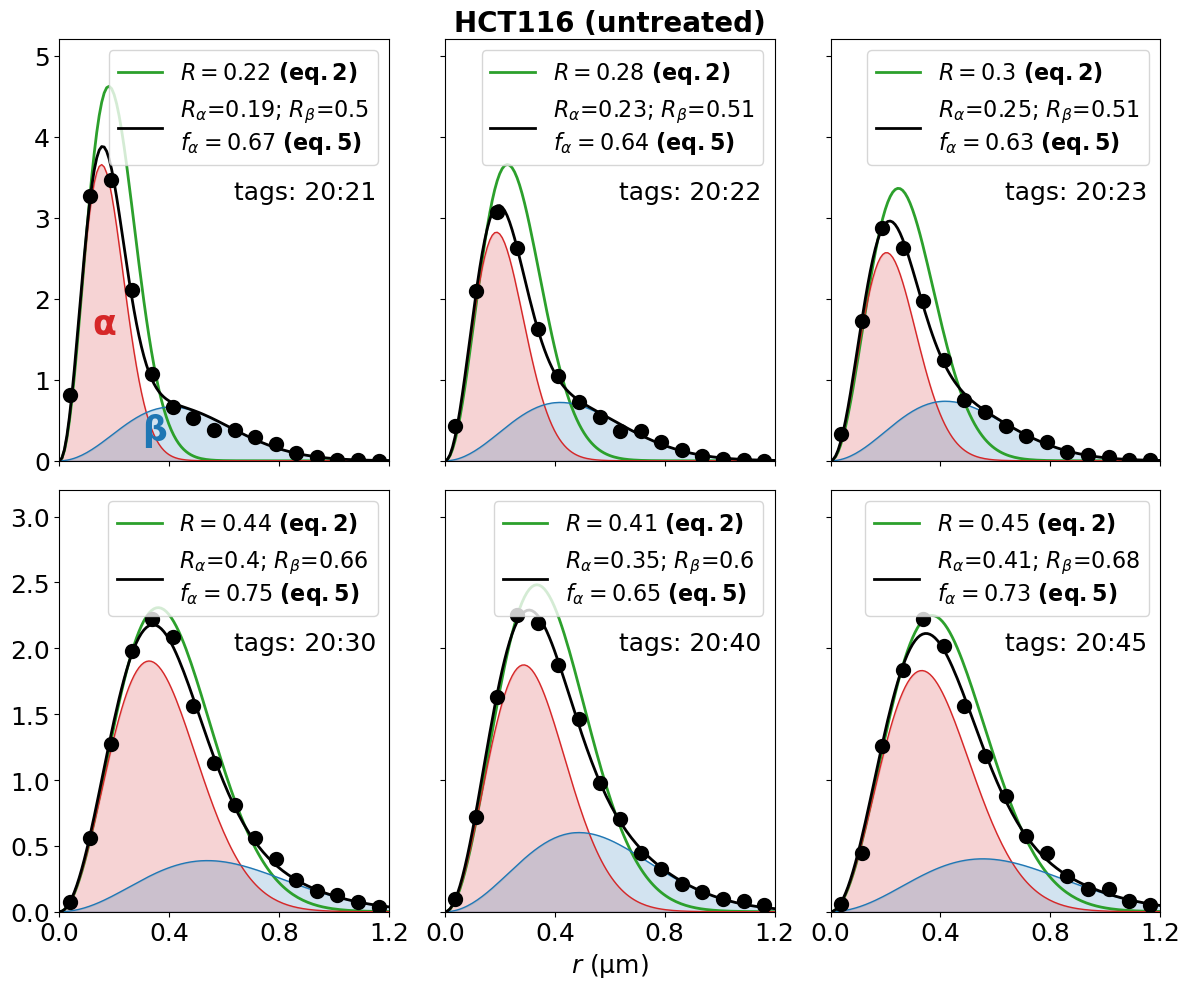

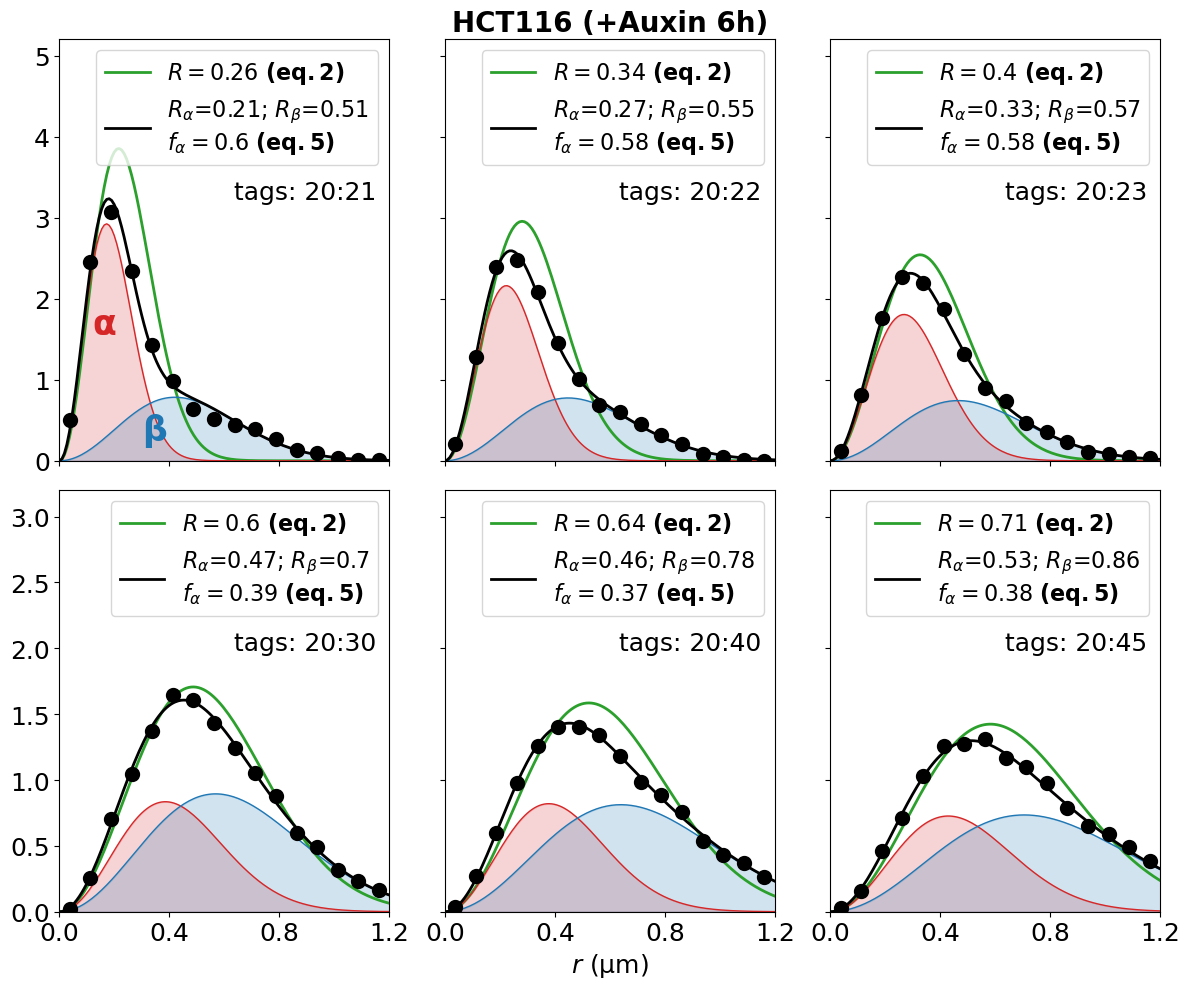

In [7]:
# Define the bins for the histogram
bins = np.linspace(0, 1.8, 25)

# Define a reference tag value
tag = 20

# Define a list of tag differences to analyze
dtag = [1, 2, 3, 10, 20, 25]

# Define subplot positions for plotting
nplots = [231, 232, 233, 234, 235, 236]

# Iterate over different cell lines ('HCT116' and 'HCT116_AUXIN')
for cell_line in ['HCT116', 'HCT116_AUXIN']:
    # Get the distance matrix for the current cell line
    dm = RESULTS[cell_line]['distmat']

    # Create a new figure for plotting
    fig = plt.figure(figsize=(12, 10))

    # Iterate over different tag differences (dtag)
    for i, dt in enumerate(dtag):
        # Extract distances based on the tag and tag difference
        rr = dm[:, tag - 1, tag + dt - 1]

        # Create a histogram and calculate bin centers
        hist, bins = np.histogram(rr, bins=bins, density=True)
        bc = 0.5 * (bins[1:] + bins[:-1])

        # Fit a Gaussian distribution to the data
        param1, pcov = curve_fit(GAUSSIAN_DISTR, bc, hist, bounds=([0], [2]))

        # Fit a weighted combination of two Gaussian distributions to the data
        param2, pcov = curve_fit(TWO_GAUSSIAN_DISTR, bc, hist, bounds=([0, 0, 0], [1, 2, 1]))

        # Create a range for plotting
        rr = np.linspace(0, 1.8, 200)

        # Add a subplot to the figure
        ax = fig.add_subplot(nplots[i])

        # Customize the first subplot with a title
        if nplots[i] == 232:
            name = RESULTS[cell_line]['name']
            plt.title(f'{name}', fontsize=20, fontweight='bold')

        # Plot the Gaussian distribution with parameters and labels
        plt.plot(rr, GAUSSIAN_DISTR(rr, *param1), c='tab:green', lw=2, label=r'$R=$' + str(np.round(param1[0], 2)) + r' $\mathbf{(eq. 2)}$')
        plt.fill_between(rr, param2[2] * GAUSSIAN_DISTR(rr, param2[0]), color='tab:red', alpha=0.2)
        plt.plot(rr, param2[2] * GAUSSIAN_DISTR(rr, param2[0]), color='tab:red', lw=1)
        plt.fill_between(rr, (1 - param2[2]) * GAUSSIAN_DISTR(rr, param2[1]), color='tab:blue', alpha=0.2)
        plt.plot(rr, (1 - param2[2]) * GAUSSIAN_DISTR(rr, param2[1]), color='tab:blue', lw=1)
        
        # Add labels for the weighted Gaussian distribution
        label = r'$R_\alpha$=' + str(np.round(param2[0], 2)) + r'; $R_\beta$=' + str(np.round(param2[1], 2)) + '\n' + r'$f_\alpha=$' + str(np.round(param2[2], 2)) + r' $\mathbf{(eq. 5)}$'
        plt.plot(rr, TWO_GAUSSIAN_DISTR(rr, *param2), c='black', lw=2, label=label)

        # Plot the data points
        plt.plot(bc, hist, 'o', ms=8, mew=3, mec='black', c='black')

        # Customize plot limits and legend position
        plt.xlim([0, 1.2])
        if nplots[i] in [231, 232, 233]:
            plt.ylim([0, 5.2])
        if nplots[i] in [234, 235, 236]:
            plt.ylim([0, 3.2])
        plt.legend(loc='upper right', fontsize=16)

        # Add text with tag information
        plt.text(0.96, 0.62, f'tags: {tag}:{tag+dt}', transform=ax.transAxes, fontsize=18, ha='right')

        # Customize plot appearance
        if nplots[i] in [231]:
            plt.text(0.1, 0.3, r'$\mathbf{\alpha}$', transform=ax.transAxes, fontsize=25, color='tab:red')
            plt.text(0.25, 0.05, r'$\mathbf{\beta}$', transform=ax.transAxes, fontsize=25, color='tab:blue')
        plt.tick_params(labelsize=18)
        if nplots[i] in [ 235]:
            plt.xlabel(r'$r$ (µm)', size=18)
        if nplots[i] in [231]:
            plt.xticks([0, 0.4, 0.8, 1.2], [])
        if nplots[i] in [232, 233]:
            plt.xticks([0, 0.4, 0.8, 1.2], [])
            plt.yticks([0, 1, 2, 3, 4, 5], [])
        if nplots[i] in [235, 236]:
            plt.yticks([0, 1,  2, 3], [])
        if nplots[i] > 233:
            plt.xticks([0, 0.4, 0.8, 1.2])

    # Adjust the layout for better presentation
    plt.tight_layout()
    name = RESULTS[cell_line]['name']

    # Uncomment the following line to save the plot as an SVG file
    # plt.savefig(f'{name}_distr.svg', facecolor='white', dpi=500)

    # Display the plot
    plt.show()


## 3.1.2 IMR90 and K562 cell lines

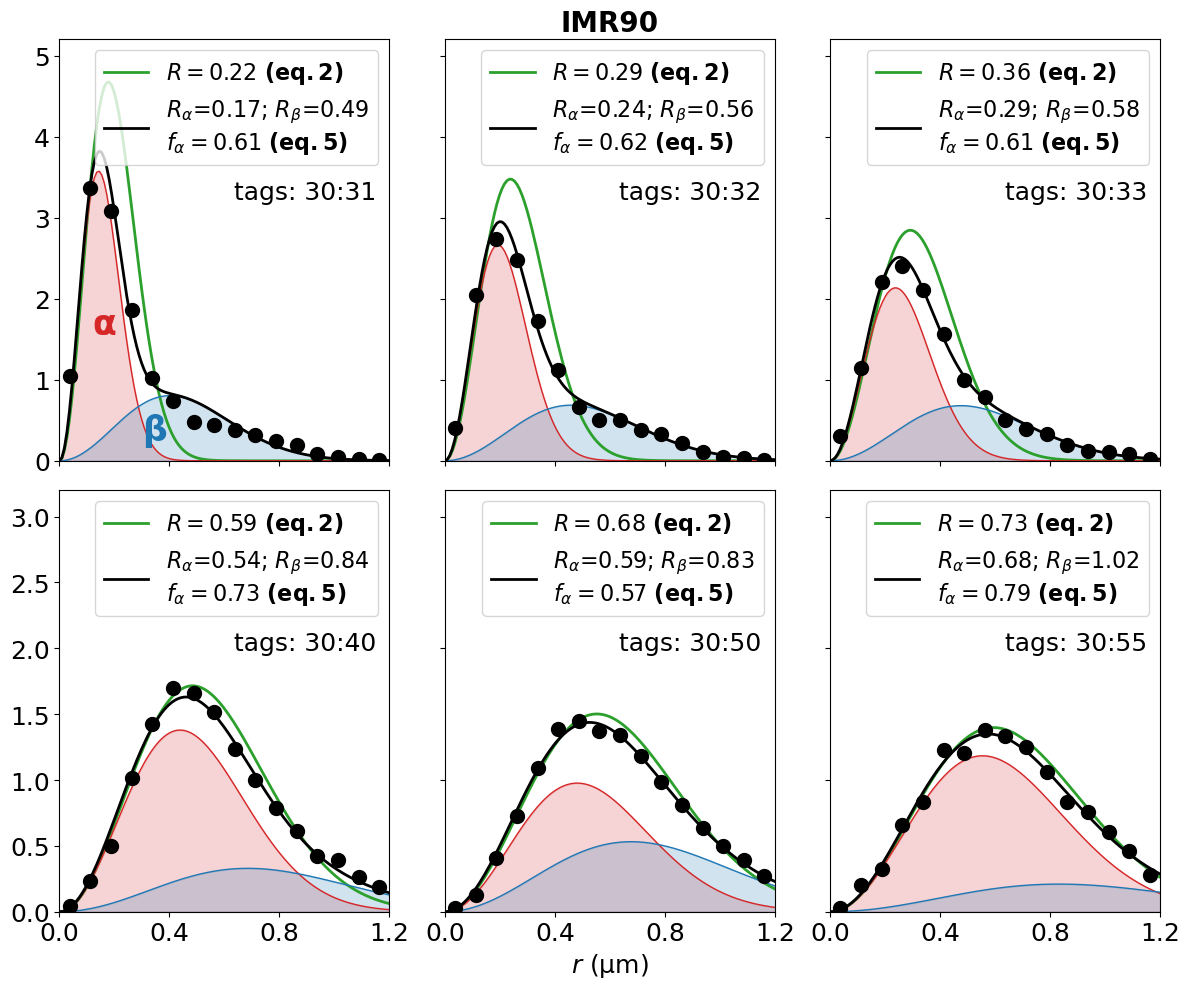

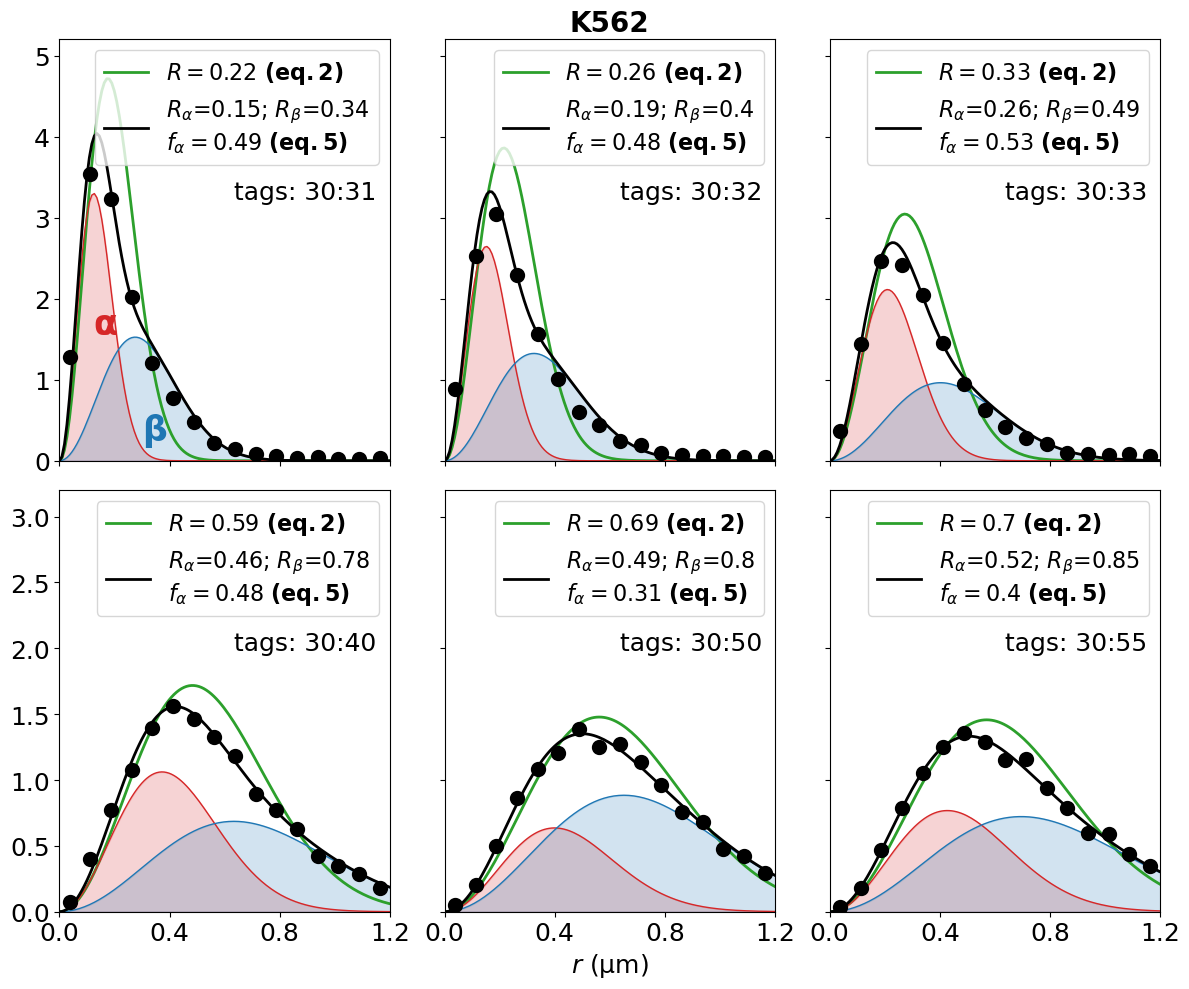

In [8]:
# Define the bins for the histogram
bins = np.linspace(0, 1.8, 25)

# Define a reference tag value
tag = 30

# Define a list of tag differences to analyze
dtag = [1, 2, 3, 10, 20, 25]

# Define subplot positions for plotting
nplots = [231, 232, 233, 234, 235, 236]

# Iterate over different cell lines ('IMR90' and 'K562')
for cell_line in ['IMR90', 'K562']:
    # Get the distance matrix for the current cell line
    dm = RESULTS[cell_line]['distmat']

    # Create a new figure for plotting
    fig = plt.figure(figsize=(12, 10))

    # Iterate over different tag differences (dtag)
    for i, dt in enumerate(dtag):
        # Extract distances based on the tag and tag difference
        rr = dm[:, tag - 1, tag + dt - 1]

        # Create a histogram and calculate bin centers
        hist, bins = np.histogram(rr, bins=bins, density=True)
        bc = 0.5 * (bins[1:] + bins[:-1])

        # Fit a Gaussian distribution to the data
        param1, pcov = curve_fit(GAUSSIAN_DISTR, bc, hist, bounds=([0], [2]))

        # Fit a weighted combination of two Gaussian distributions to the data
        param2, pcov = curve_fit(TWO_GAUSSIAN_DISTR, bc, hist, bounds=([0, 0, 0], [1, 2, 1]))

        # Create a range for plotting
        rr = np.linspace(0, 1.8, 200)

        # Add a subplot to the figure
        ax = fig.add_subplot(nplots[i])

        # Customize the first subplot with a title
        if nplots[i] == 232:
            name = RESULTS[cell_line]['name']
            plt.title(f'{name}', fontsize=20, fontweight='bold')

        # Plot the Gaussian distribution with parameters and labels
        plt.plot(rr, GAUSSIAN_DISTR(rr, *param1), c='tab:green', lw=2, label=r'$R=$' + str(np.round(param1[0], 2)) + r' $\mathbf{(eq. 2)}$')
        plt.fill_between(rr, param2[2] * GAUSSIAN_DISTR(rr, param2[0]), color='tab:red', alpha=0.2)
        plt.plot(rr, param2[2] * GAUSSIAN_DISTR(rr, param2[0]), color='tab:red', lw=1)
        plt.fill_between(rr, (1 - param2[2]) * GAUSSIAN_DISTR(rr, param2[1]), color='tab:blue', alpha=0.2)
        plt.plot(rr, (1 - param2[2]) * GAUSSIAN_DISTR(rr, param2[1]), color='tab:blue', lw=1)
        
        # Add labels for the weighted Gaussian distribution
        label = r'$R_\alpha$=' + str(np.round(param2[0], 2)) + r'; $R_\beta$=' + str(np.round(param2[1], 2)) + '\n' + r'$f_\alpha=$' + str(np.round(param2[2], 2)) + r' $\mathbf{(eq. 5)}$'
        plt.plot(rr, TWO_GAUSSIAN_DISTR(rr, *param2), c='black', lw=2, label=label)

        # Plot the data points
        plt.plot(bc, hist, 'o', ms=8, mew=3, mec='black', c='black')

        # Customize plot limits and legend position
        plt.xlim([0, 1.2])
        if nplots[i] in [231, 232, 233]:
            plt.ylim([0, 5.2])
        if nplots[i] in [234, 235, 236]:
            plt.ylim([0, 3.2])
        plt.legend(loc='upper right', fontsize=16)

        # Add text with tag information
        plt.text(0.96, 0.62, f'tags: {tag}:{tag+dt}', transform=ax.transAxes, fontsize=18, ha='right')

        # Customize plot appearance
        if nplots[i] in [231]:
            plt.text(0.1, 0.3, r'$\mathbf{\alpha}$', transform=ax.transAxes, fontsize=25, color='tab:red')
            plt.text(0.25, 0.05, r'$\mathbf{\beta}$', transform=ax.transAxes, fontsize=25, color='tab:blue')
        plt.tick_params(labelsize=18)
        if nplots[i] in [ 235]:
            plt.xlabel(r'$r$ (µm)', size=18)
        if nplots[i] in [231]:
            plt.xticks([0, 0.4, 0.8, 1.2], [])
        if nplots[i] in [232, 233]:
            plt.xticks([0, 0.4, 0.8, 1.2], [])
            plt.yticks([0, 1, 2, 3, 4, 5], [])
        if nplots[i] in [235, 236]:
            plt.yticks([0, 1,  2, 3], [])
        if nplots[i] > 233:
            plt.xticks([0, 0.4, 0.8, 1.2])

    # Adjust the layout for better presentation
    plt.tight_layout()
    name = RESULTS[cell_line]['name']

    # Uncomment the following line to save the plot as an SVG file
    # plt.savefig(f'{name}_distr.svg', facecolor='white', dpi=500)

    # Display the plot
    plt.show()


## 3.2.1 Summary diagrams of $R_\alpha$, $R_\beta$ and $f_\alpha$ for all the cell lines

In [9]:



# Let's use a dictionary of distance_mats per cell line
for cl, cell_line in enumerate(['HCT116', 'HCT116_AUXIN','IMR90','K562']):
    distance_mats = RESULTS[cell_line]['distmat']
    
    ni = np.linspace(0, distance_mats.shape[1] - 1, distance_mats.shape[1], dtype=int)
    nj = np.linspace(0, distance_mats.shape[1] - 1, distance_mats.shape[1], dtype=int)
    bins = np.linspace(0, 1.8, 25)

    Re1_matrix = np.zeros((len(ni), len(nj)))
    Re2_matrix = np.zeros((len(ni), len(nj)))
    fr_matrix = np.zeros((len(ni), len(nj)))

    uniqueR_matrix = np.zeros((len(ni), len(nj)))

    for i in range(len(ni)):
        for j in range(len(nj)):
            nx = ni[i]
            ny = nj[j]

            datah = np.array(distance_mats[:, nx, ny]) 
            nn, bins = np.histogram(datah, bins)

            b0 = bins[0]
            bins2 = []
            deltab = []

            for bb in bins[1:]:
                bins2.append((bb + b0) / 2)
                deltab.append(bb - b0)
                b0 = bb
            if np.sum(nn) == 0:
                uniqueR_matrix[i,j] = uniqueR_matrix[i-1,j-1]
                print("points skipped : ",nx," : ",ny)
                continue
            else:
#                 # 1 Gaussian
#                 xx = np.linspace(0.0001, 2, 300)
#                 popt, pcov = curve_fit(GAUSSIAN_DISTR, bins2, (nn / deltab) / np.sum(nn))
#                 uniqueR_matrix[i, j] = np.round(popt[0], 2)

                # 2 Gaussians

                popt, pcov = curve_fit(TWO_GAUSSIAN_DISTR, bins2, (nn / deltab) / np.sum(nn), bounds=(0.05, [1.5, 1.5, 0.99]))

                if popt[0] < popt[1]:
                    Re1 = popt[0]
                    Re2 = popt[1]
                    fr = popt[2]
                else:
                    Re2 = popt[0]
                    Re1 = popt[1]
                    fr = 1 - popt[2]

                Re1_matrix[i, j] = np.round(Re1, 2)
                Re2_matrix[i, j] = np.round(Re2, 2)
                fr_matrix[i, j] = fr


    RESULTS[cell_line]['Re1_matrix'] = Re1_matrix
    RESULTS[cell_line]['Re2_matrix'] = Re2_matrix
    RESULTS[cell_line]['fr_matrix'] = fr_matrix
#     RESULTS[cell_line]['uniqueR_matrix'] = uniqueR_matrix

points skipped :  9  :  52
points skipped :  52  :  9


/var/folders/tq/dgzmpwks2bd9glbd8wtm_99m0000gp/T/ipykernel_19617/3883633401.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


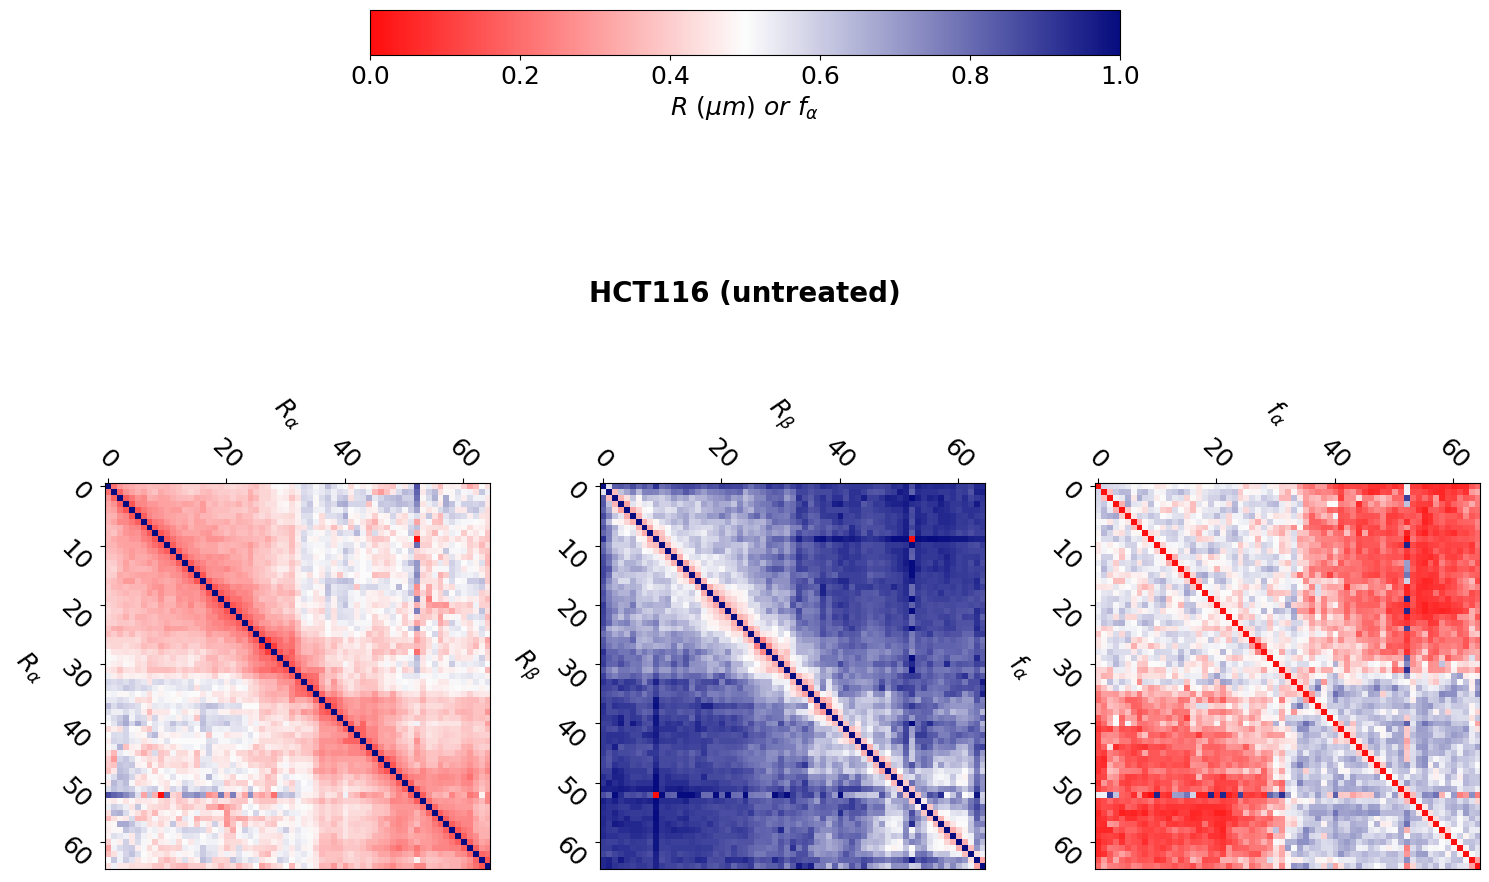

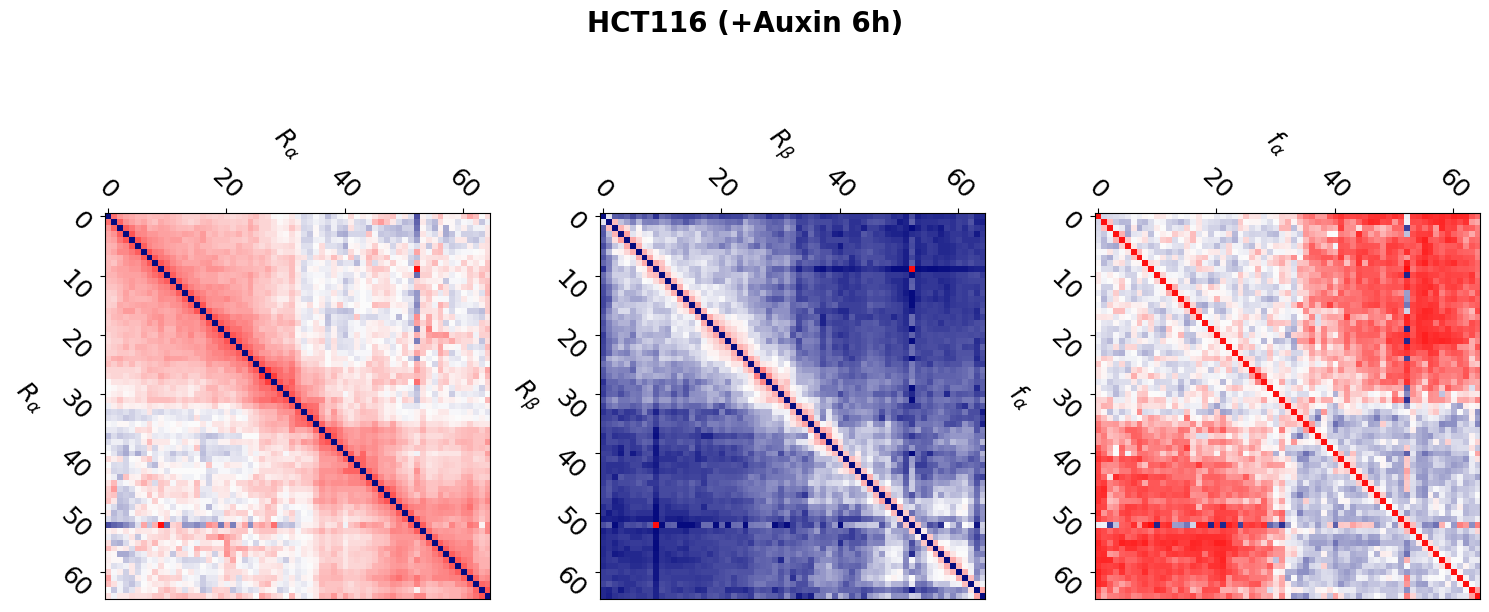

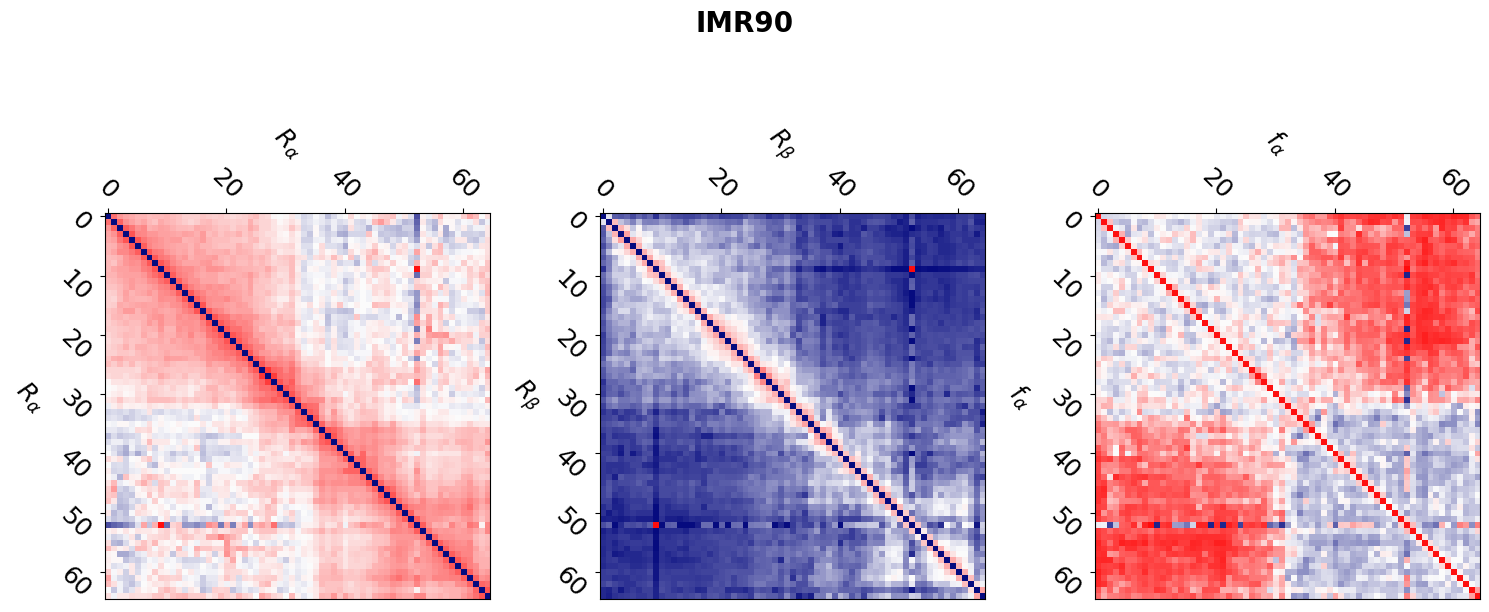

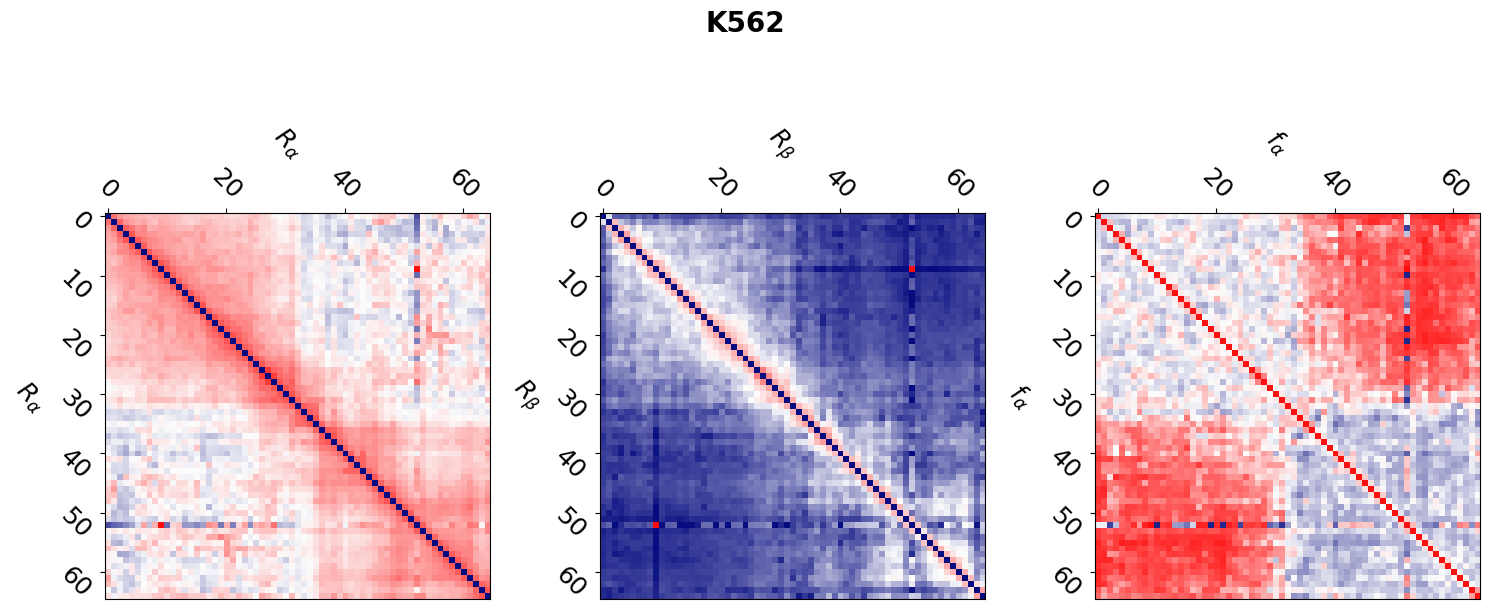

In [10]:
  # Define the color points for the custom colormap
colors = [(1, 0.05, 0.05), (0.99, 0.99, 0.99), (0.027, 0.047, 0.50)]

# Create a custom colormap with the adjusted colors
n_bins = 256
cmap_name = "custom_colormap"
custom_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
  
for cl, cell_line in enumerate(['HCT116', 'HCT116_AUXIN','IMR90','K562']):
    name = RESULTS[cell_line]['name']
   # Mask the matrices
    upper_triangle = np.triu(fr_matrix)
    upper_triangle[np.tril_indices_from(upper_triangle)] = np.nan

    lower_triangle = np.tril(1-fr_matrix)
    lower_triangle[np.triu_indices_from(lower_triangle)] = np.nan

    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    fig.suptitle(f'{name}', y=0.75, fontsize=20, fontweight='bold')  # shared title for both subplots, adjusted position

    im1 = axs[0].imshow(Re1_matrix, interpolation='nearest', cmap=custom_cmap, vmin=0, vmax=1.0)

    axs[0].yaxis.tick_left()  # move y axis ticks to right
    axs[0].xaxis.tick_top()  # ensure x axis ticks are at the bottom
    axs[0].set_xlabel(r"$R_{\alpha}$", labelpad=-335, fontsize=18, rotation=-45, rotation_mode='anchor')  # set x label at the top
    axs[0].set_ylabel(r"$R_{\alpha}$", labelpad=+25, fontsize=18, rotation=-45, rotation_mode='anchor')  # label for y axis on the left side
    axs[0].tick_params(labelsize=18,labelrotation=-45)
    
    im2 = axs[1].imshow(Re2_matrix, interpolation='nearest', cmap=custom_cmap, vmin=0, vmax=1.0)

    axs[1].yaxis.tick_left()  # move y axis ticks to right
    axs[1].xaxis.tick_top()  # ensure x axis ticks are at the bottom
    axs[1].set_xlabel(r"$R_{\beta}$", labelpad=-335, fontsize=18, rotation=-45, rotation_mode='anchor')  # set x label at the top
    axs[1].set_ylabel(r"$R_{\beta}$", labelpad=+25, fontsize=18, rotation=-45, rotation_mode='anchor')  # label for y axis on the left side
    axs[1].tick_params(labelsize=18,labelrotation=-45)
    
    im3 = axs[2].imshow(fr_matrix, interpolation='nearest', cmap=custom_cmap, vmin=0, vmax=1)

    axs[2].yaxis.tick_left()  # move y axis ticks to right
    axs[2].xaxis.tick_top()  # ensure x axis ticks are at the bottom

    axs[2].set_xlabel(r"$f_{\alpha}$", labelpad=-335, fontsize=18, rotation=-45, rotation_mode='anchor')  # set x label at the top
    axs[2].set_ylabel(r"$f_{\alpha}$", labelpad=+25, fontsize=18, rotation=-45, rotation_mode='anchor')  # label for y axis on the left side
    axs[2].tick_params(labelsize=18,labelrotation=-45)

    
    # Add colorbar only for the first cell line
    if cl == 0:
        cax1 = fig.add_axes([0.25, 0.9, 0.5, 0.03])  # Create new axes at the top middle
        cbar1 = fig.colorbar(im1, cax=cax1, orientation='horizontal')
        cbar1.set_label(r"$R\ (\mu m)\ or\ f_\alpha$", fontsize=18, rotation=-0)
        cbar1.ax.tick_params(labelsize=18, rotation=0)

    plt.tight_layout()
#     plt.subplots_adjust(top=0.85)
#     fig.savefig(cell_line+'_diagrams.pdf')
    plt.show()
  

## 3.2.2 Average $f_\alpha$ log plots vs the genomic distance (bp)

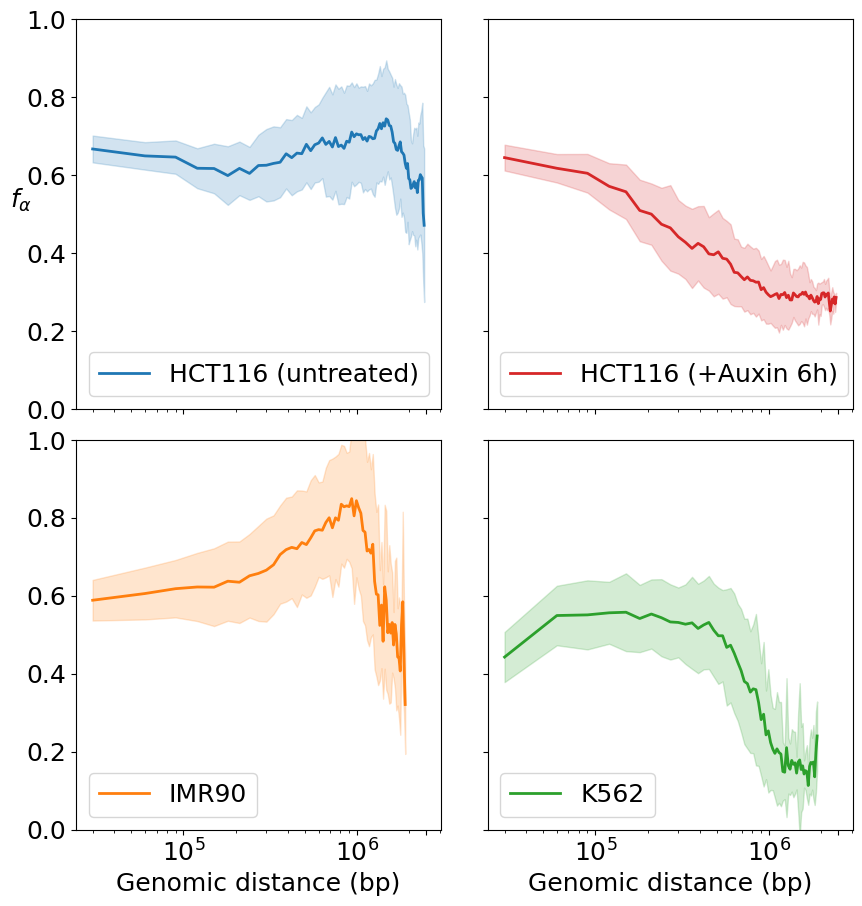

In [13]:


fig, axs = plt.subplots(2, 2, figsize=(9, 9), sharex='col', sharey='row')
for cl, cell_line in enumerate(['HCT116', 'HCT116_AUXIN','IMR90','K562']):
    name = RESULTS[cell_line]['name']
    fr_matrix = RESULTS[cell_line]['fr_matrix']
    color = RESULTS[cell_line]['color']
    mean_values = []
    std_values =[]
    x_range = range(1, fr_matrix.shape[1] - 1)

    # Calculate the mean for each i and i + x pair
    for x in x_range:
        mean_values.append(np.mean([fr_matrix[i, i + x] for i in range(fr_matrix.shape[0] - x)]))
        std_values.append(np.std([fr_matrix[i, i + x] for i in range(fr_matrix.shape[0] - x)]))

    mean_values = np.array(mean_values)
    std_values = np.array(std_values)

    f_lower = mean_values - std_values
    f_upper = mean_values + std_values

    # Plot the data
    ax = axs[cl // 2, cl % 2]
    ax.plot(np.array(x_range)*30000, mean_values,linewidth=2 ,color=color, label=name)
    ax.fill_between(np.array(x_range)*30000, f_lower, f_upper,color=color, alpha=0.2)

    # Set the title for each subplot
    ax.legend(fontsize=18, loc='lower left')
    
    ax.set_xscale('log')

    # Set the ticks font size
    ax.tick_params(axis='both', which='both', labelsize=18)
    ax.set_ylim(0, 1)

    if cl > 1:
        ax.set_xlabel('Genomic distance (bp)', fontsize=18)
        ax.set_xticks([100000, 1000000, 2500000])
    else:
        ax.set_xticks([])

    if cl == 0 or i == 2:
        ax.set_ylabel(r"$f_{\alpha}$", fontsize=18, rotation=-0, rotation_mode='anchor')


plt.tight_layout(pad=0.5)
# plt.savefig("f_mean_logscale.pdf")
plt.show()


# 3.2 Scaling behavior

## 3.2.1 HCT116 cell line (+/-) Auxin: $\nu_\alpha$ and $\nu_\beta$

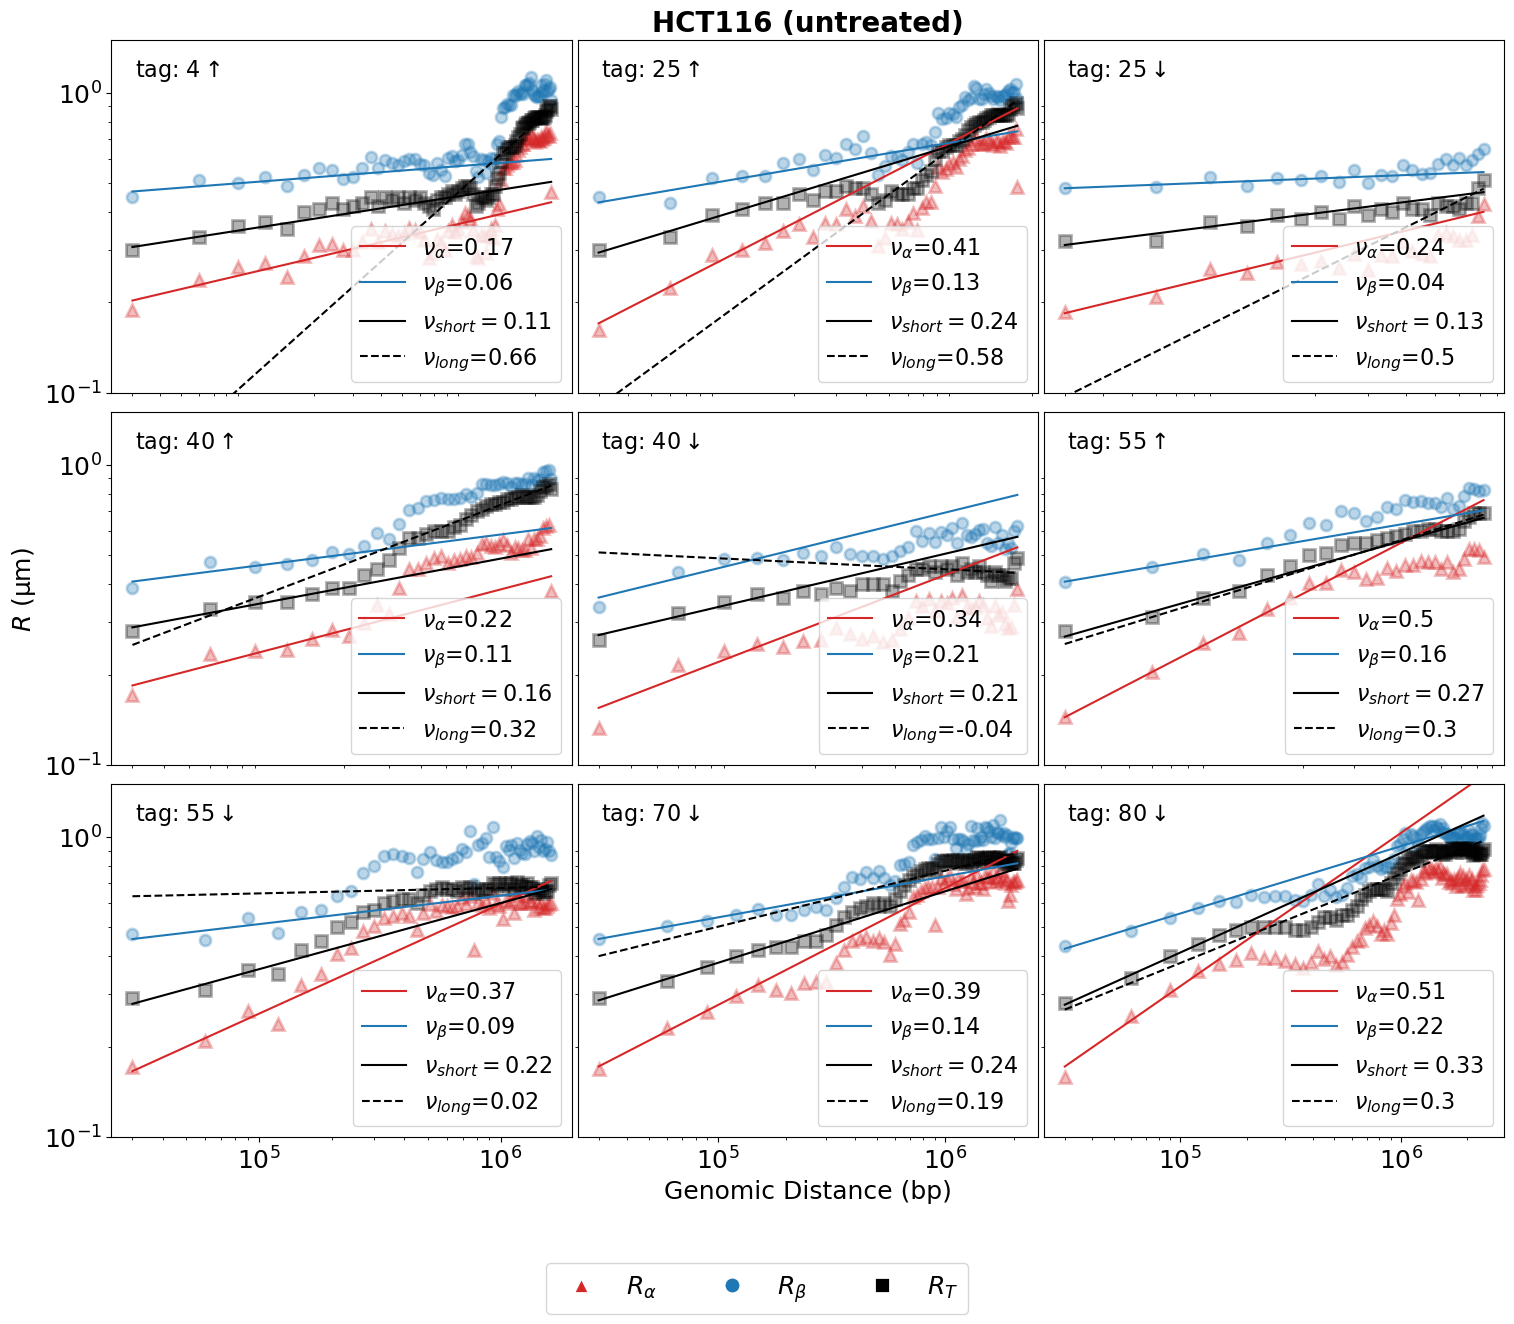

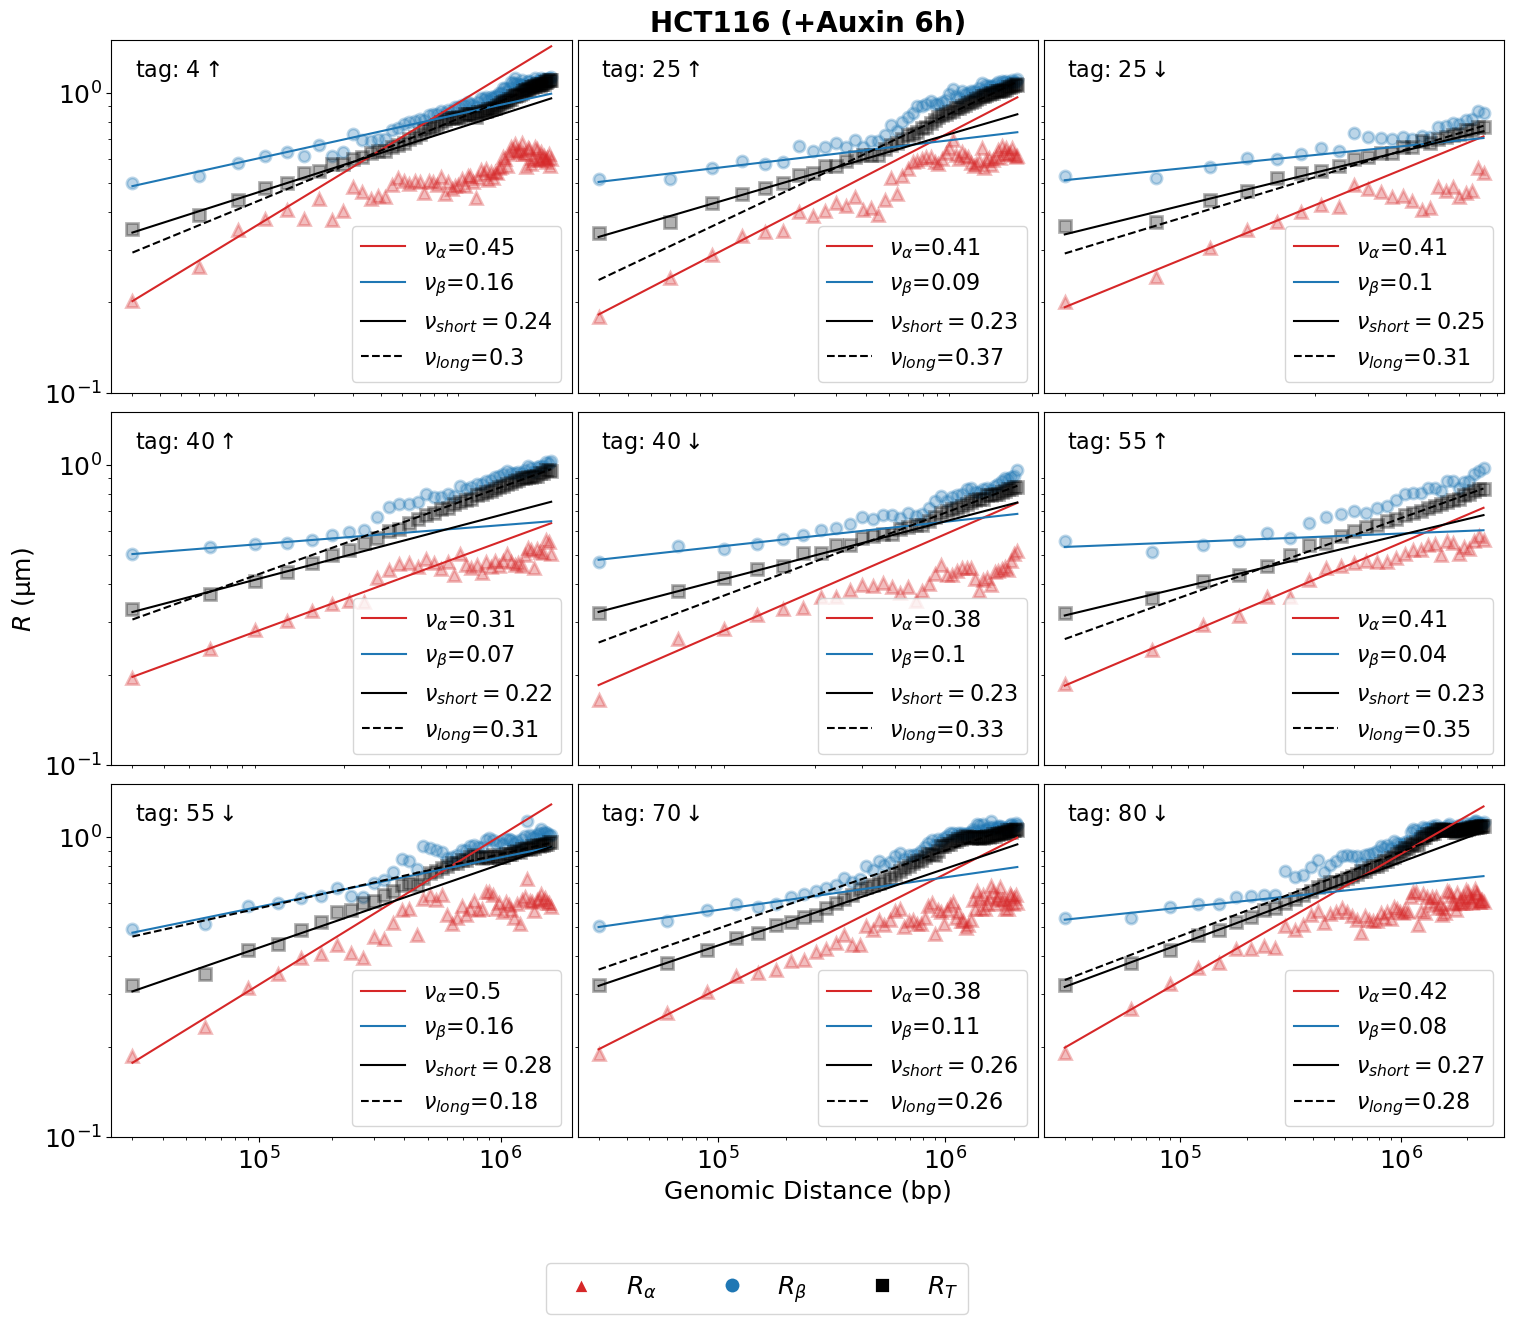

In [45]:
# Define the number of first neighboring tags used to compute the scaling behavior
n = 5

# Define the number of furthest tags used to compute the long-range scaling
n_f = 15


# Define bin edges for histogram
bins = np.linspace(0, 1.8, 25)

# Define directions, tags, and subplot positions
dirs = ['up', 'up', 'down', 'up', 'down', 'up', 'down', 'down', 'down']
tags = [4, 25, 25, 40, 40, 55, 55, 70, 80]
nplots = [331, 332, 333, 334, 335, 336, 337, 338, 339]

# Iterate over cell lines
for cell_line in ['HCT116', 'HCT116_AUXIN']:
    # Access distance matrix from RESULTS dictionary
    dm = RESULTS[cell_line]['distmat']

    # Create a figure for the plots
    fig = plt.figure(figsize=(15, 12))
    fig.subplots_adjust(hspace=0.01, wspace=0.1)

    # Iterate over tags and directions
    for i, tag in enumerate(tags):
        # Extract data based on direction
        if dirs[i] == 'up':
            dat = dm[:, tag - 1, tag - 1 + 1:]
        if dirs[i] == 'down':
            dat = np.flip(dm[:, tag - 1, :tag - 1], axis=1)

        # Perform calculations and fitting
        if len(dat[0]) > n:
            ss = []
            Ra = []
            Rb = []
            Rt = []
            for t in range(len(dat[0])):
                try:
                    hist, bins = np.histogram(dat[:, t], bins=bins, density=True)
                    bc = 0.5 * (bins[:-1] + bins[1:])
                    param2, pcov = curve_fit(TWO_GAUSSIAN_DISTR, bc, hist, bounds=([0, 0, 0], [1, 2, 1]))
                    Ra.append(param2[0])
                    Rb.append(param2[1])
                    ss.append(30000 * (t + 1))
                except:
                    print(f'all nan entries for tag {tag}')

            Rt = np.round(np.sqrt(np.nanmean(dat**2, axis=0)), 2)

            pa, pcov = curve_fit(power_function, ss[:n], Ra[:n])
            pb, pcov = curve_fit(power_function, ss[:n], Rb[:n])
            pt, pcov = curve_fit(power_function, ss[:n], Rt[:n])
            if len(Rt) > n_f+n:
                pt_end, pcov = curve_fit(power_function, ss[n_f:], Rt[n_f:])
            

            # Add subplots
            ax = fig.add_subplot(nplots[i])

            # Plot data and fitted curves
            plt.loglog(ss, Ra, '^', c='tab:red', ms=8, mew=2, alpha=0.3)
            plt.loglog(ss, Rb, 'o', c='tab:blue', ms=8, mew=2, alpha=0.3)
            plt.loglog(ss, Rt, 's', c='k', ms=8, mew=2, alpha=0.3)

            plt.loglog(ss, power_function(ss, *pa), c='tab:red', label=r'$\nu_\alpha$=' + f'{np.round(pa[1], 2)}')
            plt.loglog(ss, power_function(ss, *pb), c='tab:blue', label=r'$\nu_\beta$=' + f'{np.round(pb[1], 2)}')
           
            plt.loglog(ss, power_function(ss, *pt), c='k', label=r'$\nu_{short}=$' + f'{np.round(pt[1], 2)}')
            plt.loglog(ss, power_function(ss, *pt_end), '--', c='k', label=r'$\nu_{long}$=' + f'{np.round(pt_end[1], 2)}')

            # Set y-axis limit
            plt.ylim([0.1, 1.5])

            # Add text label indicating direction
            if dirs[i] == 'up':
                plt.text(0.05, 0.95, f'tag: {tag}' + r'$\uparrow$', transform=ax.transAxes, size=16, ha='left', va='top')
            if dirs[i] == 'down':
                plt.text(0.05, 0.95, f'tag: {tag}' + r'$\downarrow$', transform=ax.transAxes, size=16, ha='left', va='top')

            # Modify tick labels based on subplot position
            if nplots[i] in [332, 333, 335, 336]:
                plt.xticks([], [])
                plt.yticks([], [])
            if nplots[i] in [331, 334]:
                plt.xticks([], [])
            if nplots[i] in [338, 339]:
                plt.yticks([], [])

            # Add subplot legend, labels, and adjust tick sizes
            plt.legend(loc='lower right', ncol=1, fontsize=16)
            plt.tick_params(labelsize=18)

            # Add y-label for specific subplots
            if nplots[i] in [334]:
                plt.ylabel(r'$R$ (µm)', size=18)
            if nplots[i] in [338]:
                plt.xlabel(r'Genomic Distance (bp)', size=18)

            # Set title for a specific subplot
            if nplots[i] == 332:
                name = RESULTS[cell_line]['name']
                plt.title(f'{name}', fontsize=20, fontweight='bold')

    # Create a common legend for R_alpha, R_beta, and R_T outside the loop
    legend_labels = [r'$R_\alpha$', r'$R_\beta$', r'$R_T$']
    handles = []
    for i, label in enumerate(legend_labels):
        handles.append(Line2D([0], [0], marker='^' if i == 0 else 'o' if i == 1 else 's', color='w', label=label, markersize=12, markerfacecolor='tab:red' if i == 0 else 'tab:blue' if i == 1 else 'k', mew=2))

    # Create a common legend for R_alpha, R_beta, and R_T
    fig.legend(handles=handles, loc='lower center', ncol=3, fontsize=18, bbox_to_anchor=(0.5, 0-0.1))

    # Ensure plots are well-arranged
    plt.tight_layout(pad=0.2)
    name = RESULTS[cell_line]['name']

    # Uncomment the following line to save the plot as an SVG file
    # plt.savefig(f'{name}_scaling.png', facecolor='white', dpi=500)

    # Show the plot
    plt.show()


## 3.2.2  HCT116 cell line (+/-) Auxin : Effective exponent $\nu_T$

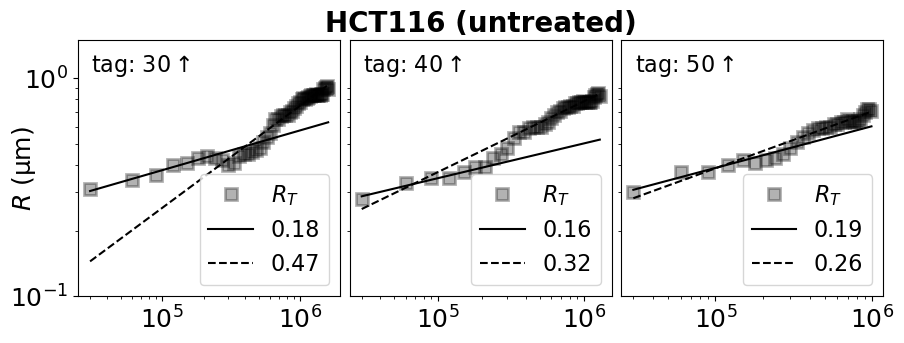

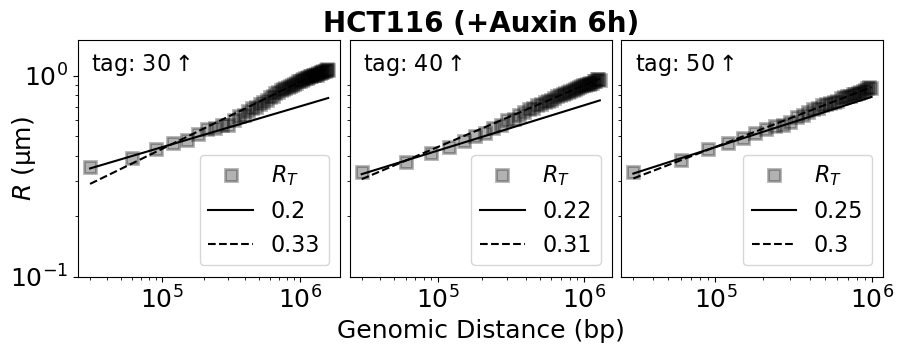

done


In [51]:
# Define the number of first neighboring tags used to compute the scaling behavior
n = 5

# Define the number of furthest tags used to compute the long-range scaling
n_f = 15


# Define bin edges for histogram
bins = np.linspace(0, 1.8, 25)

# Define directions, tags, and subplot positions
dirs = ['up', 'up', 'down', 'up', 'down', 'up', 'down', 'down', 'down']
tags = [4, 25, 25, 40, 40, 55, 55, 70, 80]
nplots = [331, 332, 333, 334, 335, 336, 337, 338, 339]

dirs = ['up', 'up', 'up']
tags = [ 30, 40,  50]
nplots = [331, 332, 333]
# Iterate over cell lines
for cell_line in ['HCT116', 'HCT116_AUXIN']:
    # Access distance matrix from RESULTS dictionary
    dm = RESULTS[cell_line]['distmat']

    # Create a figure for the plots
    fig = plt.figure(figsize=(9, 9))
    fig.subplots_adjust(hspace=0.01, wspace=0.1)

    # Iterate over tags and directions
    for i, tag in enumerate(tags):
        # Extract data based on direction
        if dirs[i] == 'up':
            dat = dm[:, tag - 1, tag - 1 + 1:]
        if dirs[i] == 'down':
            dat = np.flip(dm[:, tag - 1, :tag - 1], axis=1)

        # Perform calculations and fitting
        if len(dat[0]) > n:
            ss = []
            Ra = []
            Rb = []
            Rt = []
            for t in range(len(dat[0])):
                try:
                    hist, bins = np.histogram(dat[:, t], bins=bins, density=True)
                    bc = 0.5 * (bins[:-1] + bins[1:])
                    param2, pcov = curve_fit(TWO_GAUSSIAN_DISTR, bc, hist, bounds=([0, 0, 0], [1, 2, 1]))
                    Ra.append(param2[0])
                    Rb.append(param2[1])
                    ss.append(30000 * (t + 1))
                except:
                    print(f'all nan entries for tag {tag}')

            Rt = np.round(np.sqrt(np.nanmean(dat**2, axis=0)), 2)

            pa, pcov = curve_fit(power_function, ss[:n], Ra[:n])
            pb, pcov = curve_fit(power_function, ss[:n], Rb[:n])
            pt, pcov = curve_fit(power_function, ss[:n], Rt[:n])
            if len(Rt) > n_f+n:
                pt_end, pcov = curve_fit(power_function, ss[n_f:], Rt[n_f:])

            # Add subplots
            ax = fig.add_subplot(nplots[i])

            # Plot data and fitted curves
            #plt.loglog(ss, Ra, '^', c='tab:red', ms=8, mew=2, alpha=0.3)
            #plt.loglog(ss, Rb, 'o', c='tab:blue', ms=8, mew=2, alpha=0.3)
            plt.loglog(ss, Rt, 's', c='k', ms=8, mew=2, alpha=0.3, label='$R_T$')

            #plt.loglog(ss, power_function(ss, *pa), c='tab:red', label=r'$\nu_\alpha$=' + f'{np.round(pa[1], 2)}')
            #plt.loglog(ss, power_function(ss, *pb), c='tab:blue', label=r'$\nu_\beta$=' + f'{np.round(pb[1], 2)}')
            plt.loglog(ss, power_function(ss, *pt), c='k', label=f'{np.round(pt[1], 2)}')
            plt.loglog(ss, power_function(ss, *pt_end), '--', c='k', label=f'{np.round(pt_end[1], 2)}')

            # Set y-axis limit
            plt.ylim([0.1, 1.5])

            # Add text label indicating direction
            if dirs[i] == 'up':
                plt.text(0.05, 0.95, f'tag: {tag}' + r'$\uparrow$', transform=ax.transAxes, size=16, ha='left', va='top')
            if dirs[i] == 'down':
                plt.text(0.05, 0.95, f'tag: {tag}' + r'$\downarrow$', transform=ax.transAxes, size=16, ha='left', va='top')

            # Modify tick labels based on subplot position
            if nplots[i] in [332, 333, 335, 336]:
                #plt.xticks([], [])
                plt.yticks([], [])
            #if nplots[i] in [331, 334]:
                #plt.xticks([], [])
            if nplots[i] in [338, 339]:
                plt.yticks([], [])
        
            # Add subplot legend, labels, and adjust tick sizes
            plt.legend(loc='lower right', ncol=1, fontsize=16)
            plt.tick_params(labelsize=18)

            # Add y-label for specific subplots
            if nplots[i] in [331]:
                plt.ylabel(r'$R$ (µm)', size=18, labelpad=-20)

            if  cell_line == 'HCT116_AUXIN' :
                if nplots[i] in [332]:
                    plt.xlabel(r'Genomic Distance (bp)', size=18)

            # Set title for a specific subplot
            if nplots[i] == 332:
                name = RESULTS[cell_line]['name']
                plt.title(f'{name}', fontsize=20, fontweight='bold')

    # Create a common legend for R_alpha, R_beta, and R_T outside the loop
    legend_labels = [r'$R_\alpha$', r'$R_\beta$', r'$R_T$']
    handles = []
    for i, label in enumerate(legend_labels):
        handles.append(Line2D([0], [0], marker='^' if i == 0 else 'o' if i == 1 else 's', color='w', label=label, markersize=12, markerfacecolor='tab:red' if i == 0 else 'tab:blue' if i == 1 else 'k', mew=2))

    # Create a common legend for R_alpha, R_beta, and R_T
    #fig.legend(handles=handles, loc='lower center', ncol=3, fontsize=18, bbox_to_anchor=(0.5, 0-0.1))

    # Ensure plots are well-arranged
    plt.tight_layout(pad=0.5)
    name = RESULTS[cell_line]['name']

    # Uncomment the following line to save the plot as an SVG file
#     plt.savefig(f'{name}_scaling_RT.pdf')

    # Show the plot
    plt.show()
print("done")

## 3.2.3 IMR90 and K562 cell lines : $\nu_\alpha$ and $\nu_\beta$

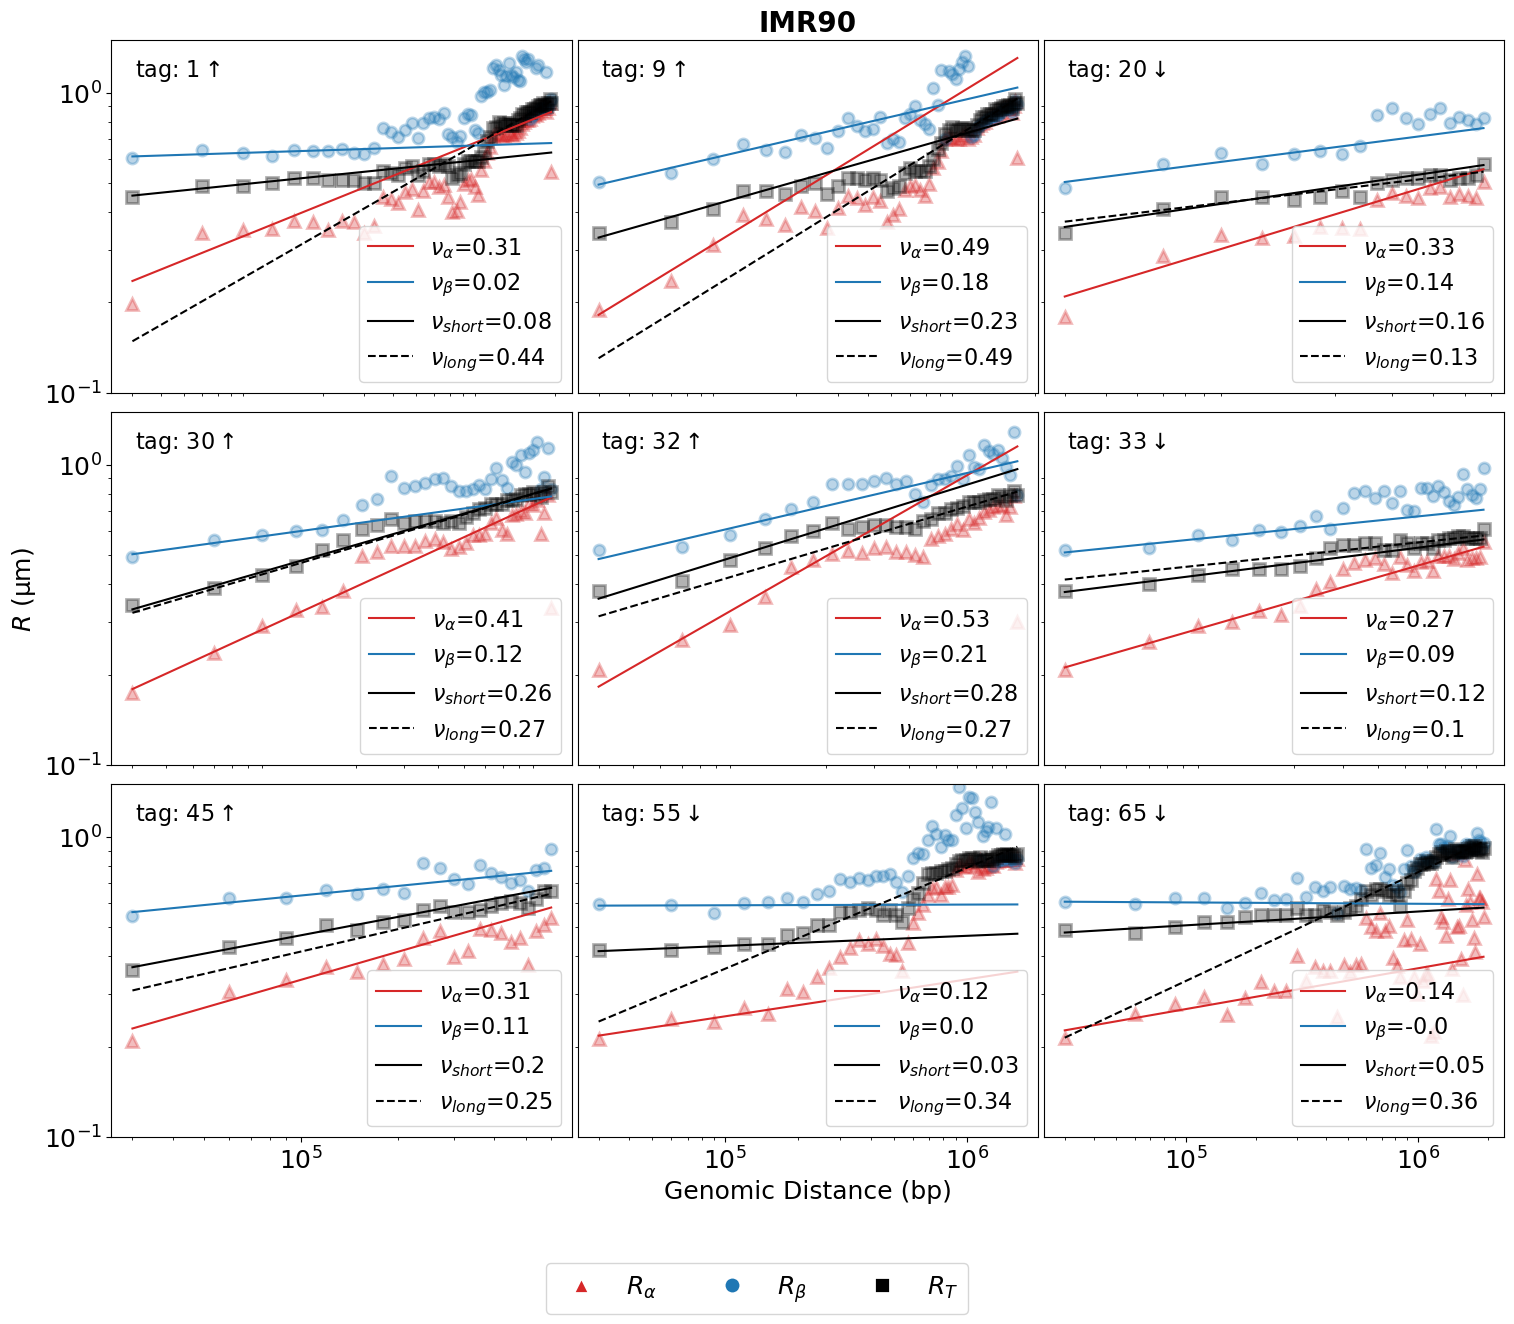

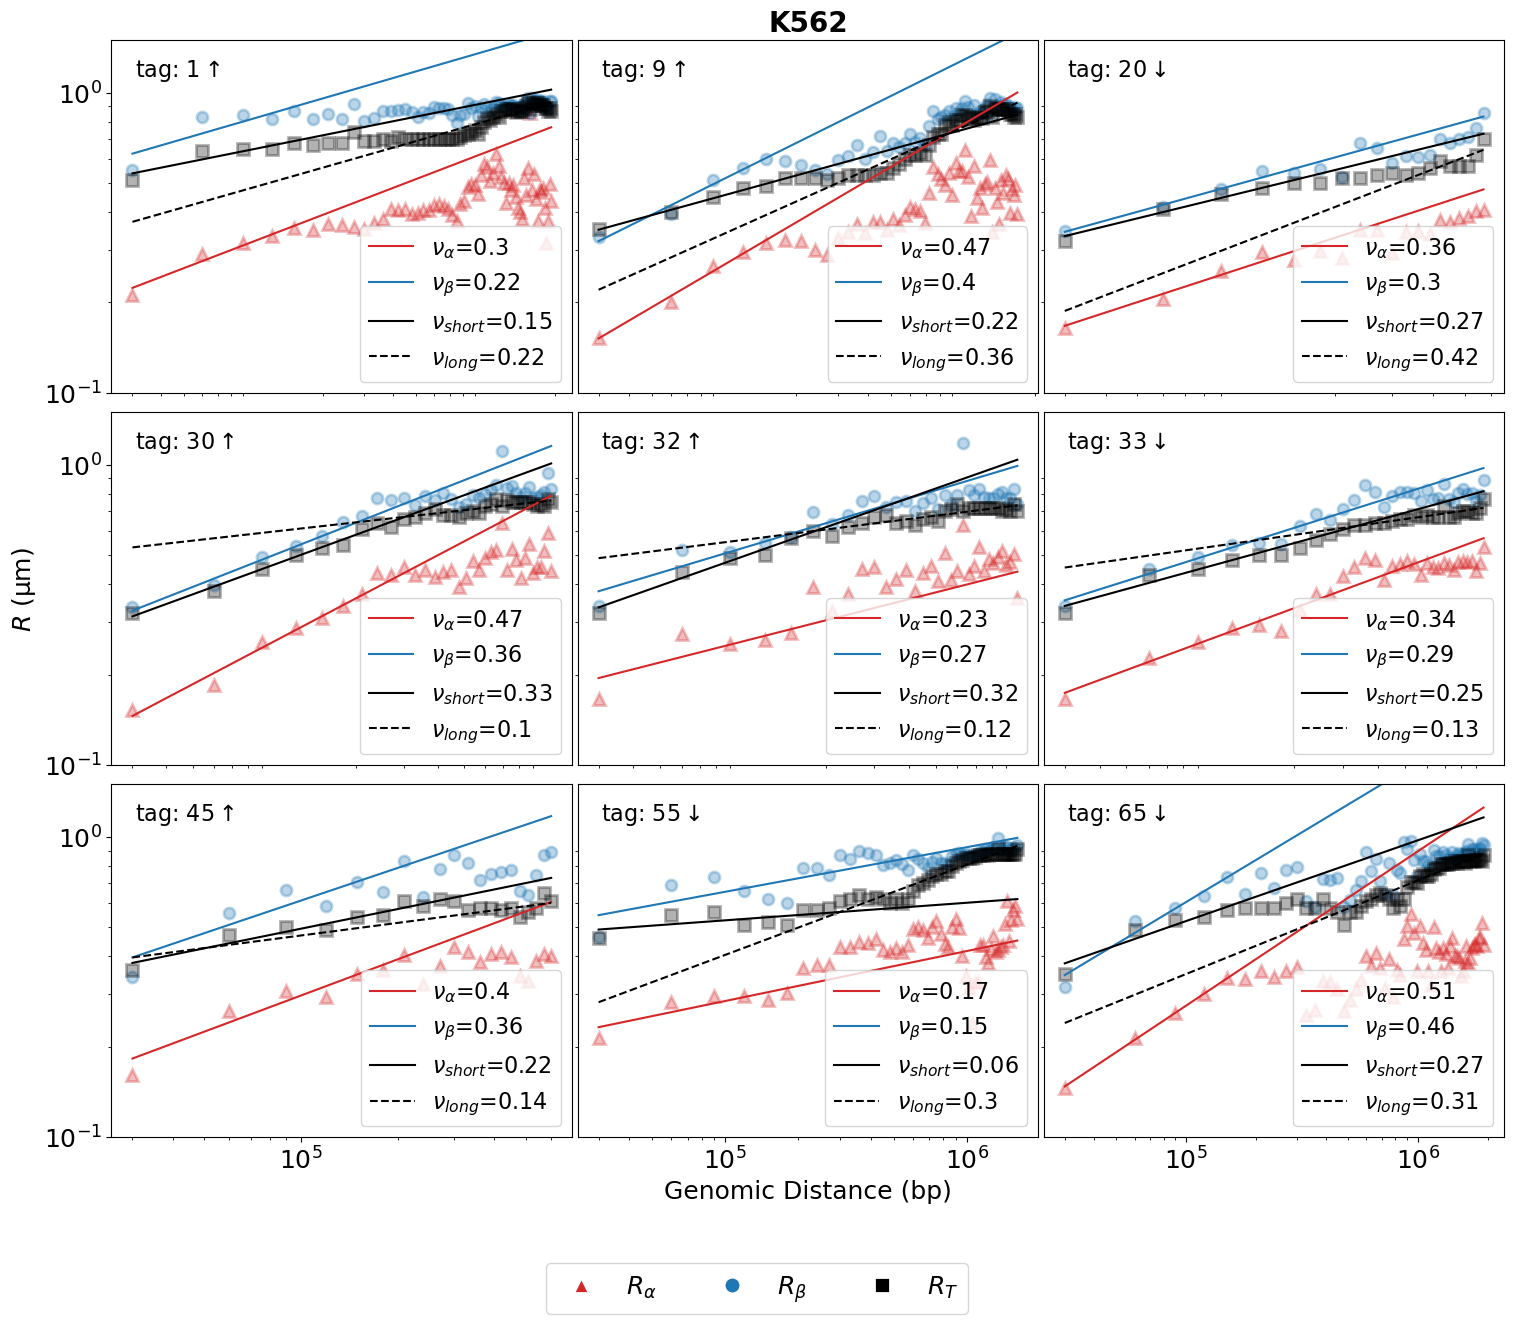

In [16]:
# Define the number of first neighboring tags used to compute the scaling behavior
n = 5

# Define the number of furthest tags used to compute the long-range scaling
n_f = 11


bins = np.linspace(0, 1.8, 25)
dirs = ['up', 'up', 'down', 'up', 'up', 'down', 'up', 'down', 'down']
tags = [1, 9, 20, 30, 32, 33, 45, 55, 65]
nplots = [331, 332, 333, 334, 335, 336, 337, 338, 339]

for cell_line in ['IMR90', 'K562']:
    dm = RESULTS[cell_line]['distmat']
    
    fig = plt.figure(figsize=(15, 12))
    fig.subplots_adjust(hspace=0.01, wspace=0.1)

    for i, tag in enumerate(tags):
 
        if dirs[i] == 'up':
            dat = dm[:, tag - 1, tag - 1 + 1:]
        if dirs[i] == 'down':
            dat = np.flip(dm[:, tag - 1, :tag - 1], axis=1)
            

        
        if len(dat[0]) > n:
            ss = []
            Ra = []
            Rb = []
            Rt = []

            for t in range(len(dat[0])):
                try:
                    hist, bins = np.histogram(dat[:, t], bins=bins, density=True)
                    bc = 0.5 * (bins[:-1] + bins[1:])
                    param2, pcov = curve_fit(TWO_GAUSSIAN_DISTR, bc, hist, bounds=([0, 0, 0], [1, 2, 1]))
                    Ra.append(param2[0])
                    Rb.append(param2[1])
                    ss.append(30000 * (t + 1))
                except:
                    print(f'all nan entries for tag {tag}')

            Rt =  np.round(np.sqrt(np.nanmean(dat**2, axis=0)), 2)

            
            pa, pcov = curve_fit(power_function, ss[:n], Ra[:n])
            pb, pcov = curve_fit(power_function, ss[:n], Rb[:n])
            pt, pcov = curve_fit(power_function, ss[:n], Rt[:n])
            if len(Rt) > n_f+n:
                pt_end, pcov = curve_fit(power_function, ss[n_f:], Rt[n_f:])

            ax = fig.add_subplot(nplots[i])

            plt.loglog(ss, Ra, '^', c='tab:red', ms=8, mew=2, alpha=0.3)
            plt.loglog(ss, Rb, 'o', c='tab:blue', ms=8, mew=2, alpha=0.3)
            plt.loglog(ss, Rt, 's', c='k', ms=8, mew=2, alpha=0.3)

            plt.loglog(ss, power_function(ss, *pa), c='tab:red', label=r'$\nu_\alpha$=' + f'{np.round(pa[1], 2)}')
            plt.loglog(ss, power_function(ss, *pb), c='tab:blue', label=r'$\nu_\beta$=' + f'{np.round(pb[1], 2)}')
            plt.loglog(ss, power_function(ss, *pt), c='k', label=r'$\nu_{short}$=' + f'{np.round(pt[1], 2)}')
            plt.loglog(ss, power_function(ss, *pt_end),'--', c='k', label=r'$\nu_{long}$=' + f'{np.round(pt_end[1], 2)}')

            plt.ylim([0.1, 1.5])


            if dirs[i] == 'up':
                plt.text(0.05, 0.95, f'tag: {tag}' + r'$\uparrow$', transform=ax.transAxes, size=16, ha='left', va='top')
            if dirs[i] == 'down':
                plt.text(0.05, 0.95, f'tag: {tag}' + r'$\downarrow$', transform=ax.transAxes, size=16, ha='left', va='top')

            if nplots[i] in [332, 333, 335, 336]:
                plt.xticks([], [])
                plt.yticks([], [])
            if nplots[i] in [331, 334]:
                plt.xticks([], [])
            if nplots[i] in [338, 339]:
                plt.yticks([], [])

            plt.legend(loc='lower right', ncol=1, fontsize=16)
            plt.tick_params(labelsize=18)

            if nplots[i] in [ 334]:
                plt.ylabel(r'$R$ (µm)', size=18)
            if nplots[i] in [ 338]:
                plt.xlabel(r'Genomic Distance (bp)', size=18)

            if nplots[i] == 332:
                name = RESULTS[cell_line]['name']
                plt.title(f'{name}', fontsize=20, fontweight='bold')

    # Create a common legend for R_alpha, R_beta, and R_T outside the loop
    legend_labels = [r'$R_\alpha$', r'$R_\beta$', r'$R_T$']
    handles = []
    for i, label in enumerate(legend_labels):
        handles.append(Line2D([0], [0], marker='^' if i == 0 else 'o' if i == 1 else 's', color='w', label=label, markersize=12, markerfacecolor='tab:red' if i == 0 else 'tab:blue' if i == 1 else 'k', mew=2))

    # Create a common legend for R_alpha, R_beta, and R_T
    fig.legend(handles=handles, loc='lower center', ncol=3, fontsize=18, bbox_to_anchor=(0.5, 0-0.1))

        
    plt.tight_layout(pad=0.2)
    name = RESULTS[cell_line]['name']

    # Uncomment the following line to save the plot as an SVG file
    # plt.savefig(f'{name}_scaling.png', facecolor='white', dpi=500)

    plt.show()


## 3.2.4 IMR90 and K562 cell lines : Effective exponent $\nu_T$

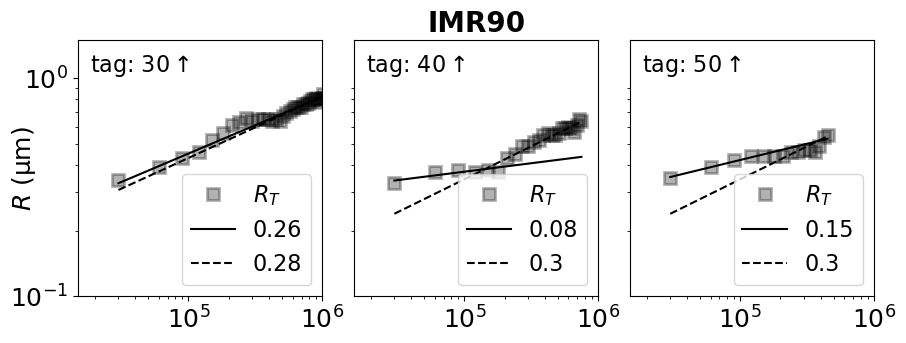

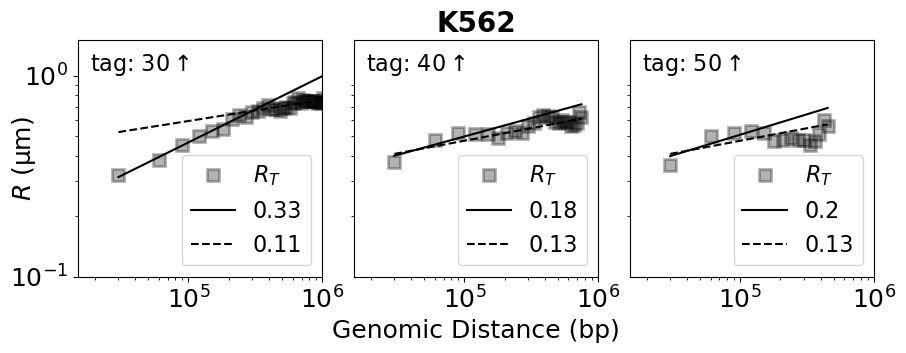

done


In [27]:
# Define the number of first neighboring tags used to compute the scaling behavior
n = 5

# Define the number of furthest tags used to compute the long-range scaling
n_f = 15


# Define bin edges for histogram
bins = np.linspace(0, 1.8, 25)

# Define directions, tags, and subplot positions
dirs = ['up', 'up', 'down', 'up', 'down', 'up', 'down', 'down', 'down']
tags = [4, 25, 25, 40, 40, 55, 55, 70, 80]
nplots = [331, 332, 333, 334, 335, 336, 337, 338, 339]

dirs = ['up', 'up', 'up']
tags = [ 30, 40,  50]
nplots = [331, 332, 333]
# Iterate over cell lines
for cell_line in ['IMR90', 'K562']:
    # Access distance matrix from RESULTS dictionary
    dm = RESULTS[cell_line]['distmat']

    # Create a figure for the plots
    fig = plt.figure(figsize=(9, 9))
    fig.subplots_adjust(hspace=0.01, wspace=0.1)

    # Iterate over tags and directions
    for i, tag in enumerate(tags):
        # Extract data based on direction
        if dirs[i] == 'up':
            dat = dm[:, tag - 1, tag - 1 + 1:]
        if dirs[i] == 'down':
            dat = np.flip(dm[:, tag - 1, :tag - 1], axis=1)

        # Perform calculations and fitting
        if len(dat[0]) > n:
            ss = []
            Ra = []
            Rb = []
            Rt = []
            for t in range(len(dat[0])):
                try:
                    hist, bins = np.histogram(dat[:, t], bins=bins, density=True)
                    bc = 0.5 * (bins[:-1] + bins[1:])
                    param2, pcov = curve_fit(TWO_GAUSSIAN_DISTR, bc, hist, bounds=([0, 0, 0], [1, 2, 1]))
                    Ra.append(param2[0])
                    Rb.append(param2[1])
                    ss.append(30000 * (t + 1))
                except:
                    print(f'all nan entries for tag {tag}')

            Rt = np.round(np.sqrt(np.nanmean(dat**2, axis=0)), 2)

            pa, pcov = curve_fit(power_function, ss[:n], Ra[:n])
            pb, pcov = curve_fit(power_function, ss[:n], Rb[:n])
            pt, pcov = curve_fit(power_function, ss[:n], Rt[:n])
            if len(Rt) > n_f+n:
                pt_end, pcov = curve_fit(power_function, ss[n_f:], Rt[n_f:])

            # Add subplots
            ax = fig.add_subplot(nplots[i])

            # Plot data and fitted curves
            #plt.loglog(ss, Ra, '^', c='tab:red', ms=8, mew=2, alpha=0.3)
            #plt.loglog(ss, Rb, 'o', c='tab:blue', ms=8, mew=2, alpha=0.3)
            plt.loglog(ss, Rt, 's', c='k', ms=8, mew=2, alpha=0.3, label='$R_T$')

            #plt.loglog(ss, power_function(ss, *pa), c='tab:red', label=r'$\nu_\alpha$=' + f'{np.round(pa[1], 2)}')
            #plt.loglog(ss, power_function(ss, *pb), c='tab:blue', label=r'$\nu_\beta$=' + f'{np.round(pb[1], 2)}')
            plt.loglog(ss, power_function(ss, *pt), c='k', label=f'{np.round(pt[1], 2)}')
            plt.loglog(ss, power_function(ss, *pt_end), '--', c='k', label=f'{np.round(pt_end[1], 2)}')

            # Set y-axis limit
            plt.ylim([0.1, 1.5])
            plt.xlim([1.5*10**4, 1*10**6])
            # Add text label indicating direction
            if dirs[i] == 'up':
                plt.text(0.05, 0.95, f'tag: {tag}' + r'$\uparrow$', transform=ax.transAxes, size=16, ha='left', va='top')
            if dirs[i] == 'down':
                plt.text(0.05, 0.95, f'tag: {tag}' + r'$\downarrow$', transform=ax.transAxes, size=16, ha='left', va='top')

            # Modify tick labels based on subplot position
            if nplots[i] in [332, 333, 335, 336]:
                #plt.xticks([], [])
                plt.yticks([], [])
            #if nplots[i] in [331, 334]:
                #plt.xticks([], [])
            if nplots[i] in [338, 339]:
                plt.yticks([], [])
        
            # Add subplot legend, labels, and adjust tick sizes
            plt.legend(loc='lower right', ncol=1, fontsize=16)
            plt.tick_params(labelsize=18)

            # Add y-label for specific subplots
            if nplots[i] in [331]:
                plt.ylabel(r'$R$ (µm)', size=18, labelpad=-20)

            if  cell_line == 'K562' :
                if nplots[i] in [332]:
                    plt.xlabel(r'Genomic Distance (bp)', size=18)

            # Set title for a specific subplot
            if nplots[i] == 332:
                name = RESULTS[cell_line]['name']
                plt.title(f'{name}', fontsize=20, fontweight='bold')

    # Create a common legend for R_alpha, R_beta, and R_T outside the loop
    legend_labels = [r'$R_\alpha$', r'$R_\beta$', r'$R_T$']
    handles = []
    for i, label in enumerate(legend_labels):
        handles.append(Line2D([0], [0], marker='^' if i == 0 else 'o' if i == 1 else 's', color='w', label=label, markersize=12, markerfacecolor='tab:red' if i == 0 else 'tab:blue' if i == 1 else 'k', mew=2))

    # Create a common legend for R_alpha, R_beta, and R_T
    #fig.legend(handles=handles, loc='lower center', ncol=3, fontsize=18, bbox_to_anchor=(0.5, 0-0.1))

    # Ensure plots are well-arranged
    plt.tight_layout(pad=0.5)
    name = RESULTS[cell_line]['name']

    # Uncomment the following line to save the plot as an PDF file
#     plt.savefig(f'{name}_scaling_RT.pdf')

    # Show the plot
    plt.show()
print("done")

# 3.3 Exponents' profiles and distributions

# 3.3.1 Function


In [63]:
def analyze_and_plot_cell_line(RESULTS, cell_line):
    # Define the value of 'n' and 'n_f' for scaling analysis
    n = 5
    n_f = 15

    bins = np.linspace(0, 1.8, 25)
    dm = RESULTS[cell_line]['distmat']  # Get the distance matrix for the current cell line
    ncells, ntags, a = dm.shape  # Get the dimensions of the distance matrix
    
    # Initialize lists for results
    va_up, vb_up, vt_up, vt_up_long = [0] * ntags, [0] * ntags, [0] * ntags, [0] * ntags
    va_down, vb_down, vt_down, vt_down_long = [0] * ntags, [0] * ntags, [0] * ntags, [0] * ntags

    # Iterate over tags and directions for scaling analysis
    for tag in range(ntags):
        dat = dm[:, tag, tag + 1:]

        if dat.shape[0] > 0 and dat.shape[1] >= n:
            Rt, Ra, Rb, ss = [], [], [], []

            # Iterate over data points for histogram analysis
            for t in range(len(dat[0])):
                try:
                    hist, bins = np.histogram(dat[:, t], bins=bins, density=True)
                    bc = 0.5 * (bins[:-1] + bins[1:])
                    param2, pcov = curve_fit(TWO_GAUSSIAN_DISTR, bc, hist, bounds=([0, 0, 0], [1, 2, 1]))
                    Ra.append(param2[0])
                    Rb.append(param2[1])
                    ss.append(30000 * (t + 1))
                except:
                    print(f'all nan entries for tag {tag}')
            Rt = np.round(np.sqrt(np.nanmean(dat**2, axis=0)), 2)

            pa, pcov = curve_fit(power_function, ss[:n], Ra[:n])
            pb, pcov = curve_fit(power_function, ss[:n], Rb[:n])
            pt, pcov = curve_fit(power_function, ss[:n], Rt[:n])
            
            if len(Rt) > n_f:
                try:
                    pt_long, pcov = curve_fit(power_function, ss[n_f:], Rt[n_f:])
                    vt_up_long[tag] = (pt_long[1])
                except:
                    print(f'all nan entries for tag {tag}')

            va_up[tag] = (pa[1])
            vb_up[tag] = (pb[1])
            vt_up[tag] = (pt[1])

        # Reverse the data for the 'down' direction
        dat = np.flip(dm[:, tag, :tag], axis=1)

        if dat.shape[0] > 0 and dat.shape[1] >= n:
            Rt, Ra, Rb, ss = [], [], [], []

            # Iterate over data points for histogram analysis
            for t in range(len(dat[0])):
                try:
                    hist, bins = np.histogram(dat[:, t], bins=bins, density=True)
                    bc = 0.5 * (bins[:-1] + bins[1:])
                    param2, pcov = curve_fit(TWO_GAUSSIAN_DISTR, bc, hist, bounds=([0, 0, 0], [1, 2, 1]))
                    Ra.append(param2[0])
                    Rb.append(param2[1])
                    ss.append(30000 * (t + 1))
                except:
                    print(f'all nan entries for tag {tag}')
            Rt = np.round(np.sqrt(np.nanmean(dat**2, axis=0)), 2)

            pa, pcov = curve_fit(power_function, ss[:n], Ra[:n])
            pb, pcov = curve_fit(power_function, ss[:n], Rb[:n])
            pt, pcov = curve_fit(power_function, ss[:n], Rt[:n])
            
            if len(Rt) > n_f:
                try:
                    pt_long, pcov = curve_fit(power_function, ss[n_f:], Rt[n_f:])
                    vt_down_long[tag] = (pt_long[1])
                except:
                    print(f'all nan entries for tag {tag}')

            va_down[tag] = (pa[1])
            vb_down[tag] = (pb[1])
            vt_down[tag] = (pt[1])

    # Combine results for 'up' and 'down' directions
    va = va_up + va_down
    vb = vb_up + vb_down
    vt = vt_up + vt_down
    vt_long = vt_up_long + vt_down_long
    
    # Calculate the mean, standard deviation, and visualize results
    mean_va = [np.mean([up, down]) if up != 0 and down != 0 else max(up, down) for up, down in zip(va_up, va_down)]
    mean_vb = [np.mean([up, down]) if up != 0 and down != 0 else max(up, down) for up, down in zip(vb_up, vb_down)]
    mean_vt = [np.mean([up, down]) if up != 0 and down != 0 else max(up, down) for up, down in zip(vt_up, vt_down)]
    mean_vt_long = [np.mean([up, down]) if up != 0 and down != 0 else max(up, down) for up, down in zip(vt_up_long, vt_down_long)]

    std_va = [np.std([up, down]) if up != 0 and down != 0 else 0.0 for up, down in zip(va_up, va_down)]
    std_vb = [np.std([up, down]) if up != 0 and down != 0 else 0.0 for up, down in zip(vb_up, vb_down)]
    std_vt = [np.std([up, down]) if up != 0 and down != 0 else 0.0 for up, down in zip(vt_up, vt_down)]
    std_vt_long = [np.std([up, down]) if up != 0 and down != 0 else 0.0 for up, down in zip(vt_up_long, vt_down_long)]

    va = np.array(va)
    vb = np.array(vb)
    vt = np.array(vt)
    vt_long = np.array(vt_long)

    # Print the results for the current cell line
    print(f'{cell_line}')
    print('va:', np.mean(mean_va), np.sqrt(np.var(mean_va)))
    print('vb:', np.mean(mean_vb), np.sqrt(np.var(mean_vb)))
    print('vt:', np.mean(mean_vt), np.sqrt(np.var(mean_vt)))
    print('vt_long:', np.mean(mean_vt_long), np.sqrt(np.var(mean_vt_long)))

    # Plot the results for scaling and density
    if cell_line in ['K562']:
        fig = plt.figure(figsize=(7.5, 4.3)) 
    else :
        fig = plt.figure(figsize=(7.5, 4))
    
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])  # Adjust the width_ratios as needed

    axes = [plt.subplot(gs[0]), plt.subplot(gs[1])]
    plt.subplots_adjust(wspace=0.2)
    axes[0].plot(range(ntags), mean_vt, color='black', label=r"$\nu_{short}$ = %.2f $\pm$ %.2f" % (np.mean(mean_vt), np.std(mean_vt)))
#     axes[0].plot(range(ntags), mean_vt_long, '--',color='black', label=r"$\nu_{long}$ = %.2f $\pm$ %.2f" % (np.mean(mean_vt_long), np.std(mean_vt_long)))

    axes[0].plot(range(ntags), mean_va, color=color_cycle[3], label=r"$\nu_{\alpha}$ = %.2f $\pm$ %.2f" % (np.mean(mean_va), np.std(mean_va)))
    axes[0].plot(range(ntags), mean_vb, color=color_cycle[0], label=r"$\nu_{\beta}$ = %.2f $\pm$ %.2f" % (np.mean(mean_vb), np.std(mean_vb)))

#     To display every single exponent (up and down) of each phase, uncomment:
#     axes[0].plot(range(ntags), va_up, '^', color=color_cycle[3])
#     axes[0].plot(range(ntags), vb_up, '^', color=color_cycle[0])
#     axes[0].plot(range(ntags), va_down, 'v', color=color_cycle[3]) 
#     axes[0].plot(range(ntags), vb_down, 'v', color=color_cycle[0])
    
    # Plot the uncertainty as transparency around the curves
    axes[0].fill_between(range(ntags), np.array(mean_vt) - np.array(std_vt), np.array(mean_vt) + np.array(std_vt), color='black', alpha=0.2)
#     axes[0].fill_between(range(ntags), np.array(mean_vt_long) - np.array(std_vt_long), np.array(mean_vt_long) + np.array(std_vt_long), color='black', alpha=0.2)

    axes[0].fill_between(range(ntags), np.array(mean_va) - np.array(std_va), np.array(mean_va) + np.array(std_va), color=color_cycle[3], alpha=0.2)
    axes[0].fill_between(range(ntags), np.array(mean_vb) - np.array(std_vb), np.array(mean_vb) + np.array(std_vb), color=color_cycle[0], alpha=0.2)

    for nu, label, color in zip([vt, va, vb], [r"$\nu_{short}$", r"$\nu_{\alpha}$", r"$\nu_{\beta}$"], ["black", color_cycle[3], color_cycle[0]]):
        num_bins = 15
        n, bins_dist = np.histogram(nu[nu > 0], bins=num_bins, density=True)
        bin_centers = (bins_dist[:-1] + bins_dist[1:]) / 2
        delta_bin = bins_dist[1] - bins_dist[0]

        # Smooth the histogram using interpolation
        smoothed_curve = np.interp(bin_centers, bin_centers, n)

        axes[1].plot(smoothed_curve, bin_centers, '-', label=label, color=color, alpha=1)
        axes[1].fill_betweenx(bin_centers, smoothed_curve, color=color, alpha=0.2)

    # Define the custom y-axis tick values as fractions
    custom_y_ticks = [0, Fraction(1/10), Fraction(1, 3), Fraction(1/2),Fraction(3/5)]

    # Format the tick labels as fractions
    axes[0].set_yticks([float(y) for y in custom_y_ticks])
    axes[0].set_yticklabels([str(Fraction(y).limit_denominator()) for y in custom_y_ticks], fontsize=18)
    

    if cell_line in ['K562']:
        axes[0].set_xlabel('i', fontsize=18)
        # Additional space for x-axis labels in the first subplot
        
    axes[0].set_ylabel(r"$\nu(i)$", fontsize=18)
    axes[0].set_ylim([0.0, 3/5+0.1])
    axes[0].set_yticklabels([str(Fraction(y).limit_denominator()) for y in custom_y_ticks])

    if cell_line in ['HCT116','HCT116_AUXIN'] :
        axes[0].set_xticks([0, 20, 40,60, 80])
    else :
        axes[0].set_xticks([0, 20, 40,60])
    axes[0].tick_params(axis='x', which='both', labelleft=True, left=True, labelsize=18)
    axes[0].tick_params(axis='y', which='both', labelleft=True, left=True, labelsize=18)

    axes[1].set_ylim([0.0, 3/5+0.05])
    axes[1].set_xlim([0.0, 15.5])
    if cell_line in ['K562']:
        axes[1].set_xlabel("Density", fontsize=18)
        # Additional space for x-axis labels in the first subplot

 
    axes[1].legend(fontsize=16, frameon=False)
    axes[1].set_xticks([0, 5, 10, 15])
    axes[1].tick_params(axis='x', which='both', labelleft=True, left=True, labelsize=18)
    axes[1].tick_params(axis='y', which='both', labelleft=False, left=True, labelsize=18)
    name = RESULTS[cell_line]['name']
    fig.suptitle(f'{name}', fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout(pad=0.2)
    plt.savefig(f'{name}_nu-dist.pdf')
    plt.show()


## 3.3.2 HTC116 (+/- Auxin)


all nan entries for tag 16


/Users/Loucif/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


all nan entries for tag 66
HCT116
va: 0.34478921038437543 0.06776099129581718
vb: 0.11648120476108031 0.049747286653612124
vt: 0.20685529038484077 0.04285055296346691
vt_long: 0.3552192806032232 0.21721452976156416


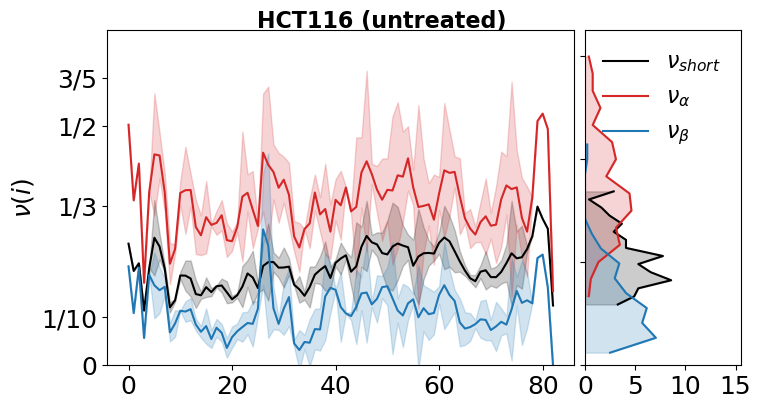

all nan entries for tag 16


/Users/Loucif/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


all nan entries for tag 66
HCT116_AUXIN
va: 0.40210683365516 0.031194061945160265
vb: 0.10141671885715962 0.02483480488365414
vt: 0.23514691659490314 0.021984000280010567
vt_long: 0.29332881782973763 0.028077144788860184


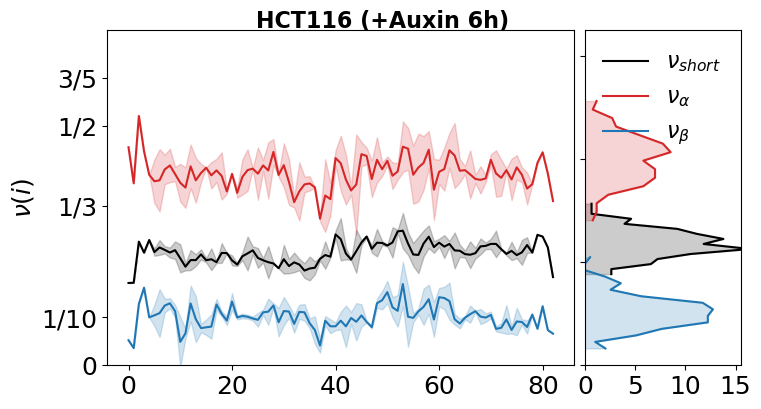

In [62]:
# Iterate over the specified cell lines and analyze/plot each of them
for cell_line in ['HCT116', 'HCT116_AUXIN']:
    analyze_and_plot_cell_line(RESULTS, cell_line)

## 3.3.3 IMR90 and K562


all nan entries for tag 16
all nan entries for tag 17


/Users/Loucif/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


all nan entries for tag 48
IMR90
va: 0.29126481273802973 0.08022352908283076
vb: 0.10503498519426428 0.04352377342502859
vt: 0.13997782819407145 0.045243728122393356
vt_long: 0.33771859513019703 0.13930315319495223


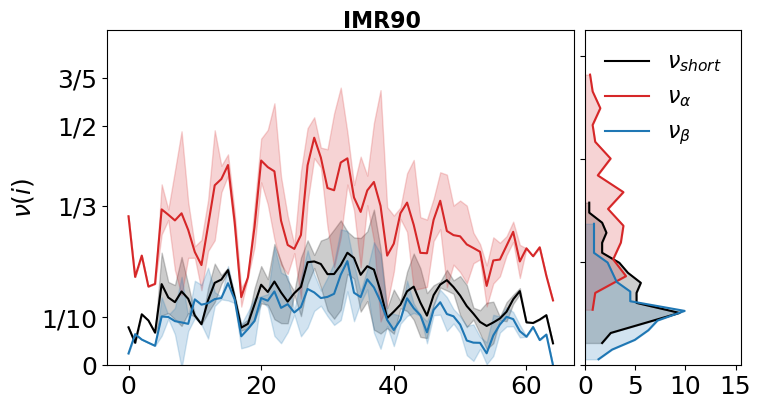

/Users/Loucif/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/var/folders/tq/dgzmpwks2bd9glbd8wtm_99m0000gp/T/ipykernel_19617/4020054850.py:32: RuntimeWarning: Mean of empty slice
  Rt = np.round(np.sqrt(np.nanmean(dat**2, axis=0)), 2)


all nan entries for tag 9
all nan entries for tag 9
all nan entries for tag 16
all nan entries for tag 17
all nan entries for tag 18
all nan entries for tag 47
all nan entries for tag 48
all nan entries for tag 52
all nan entries for tag 52


/var/folders/tq/dgzmpwks2bd9glbd8wtm_99m0000gp/T/ipykernel_19617/4020054850.py:66: RuntimeWarning: Mean of empty slice
  Rt = np.round(np.sqrt(np.nanmean(dat**2, axis=0)), 2)


K562
va: 0.36671996114116784 0.07845041343622876
vb: 0.33290187416133077 0.07449073335353405
vt: 0.2362265877145105 0.05417270151259345
vt_long: 0.25076465752316074 0.13592820167110664


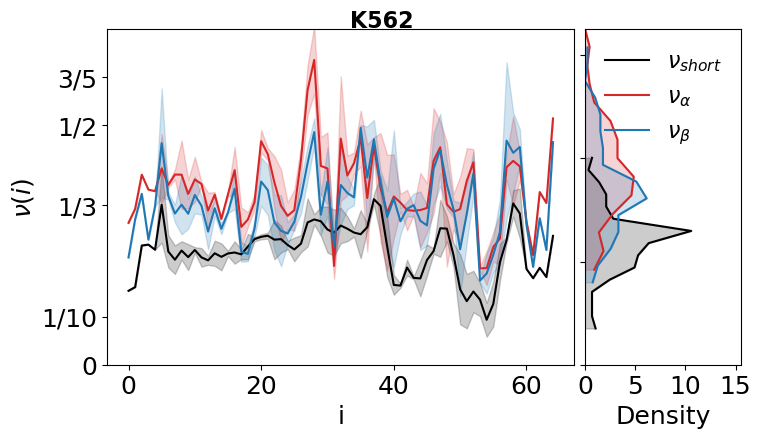

In [64]:
for cell_line in ['IMR90','K562']:
    analyze_and_plot_cell_line(RESULTS, cell_line)

# 3.4 Single cell beta phase detection

# 3.4.1 Functions

In [16]:
def CompleteHistogram(zxys,n,bins=np.linspace(0,1.8,25),interpolate=False,density=True,bins_center=False):
    """
    Compute a histogram of pairwise distances within the dataset.

    :param zxys: The spatial data points (coordinates).
    :param n: The offset to consider when computing pairwise distances.
    :param bins: The bin edges for the histogram (default: equally spaced bins from 0 to 1.8).
    :param interpolate: Flag to indicate whether to interpolate the data (default: False).
    :param density: Flag to normalize the histogram (default: True).
    :param bins_center: Flag to center bin edges on data points (default: False).
    :return: hist: The histogram values.
    :return: bins: The bin edges.
    """
    if interpolate: zxys=INTERPOLATE_ZXY(zxys)
    if bins_center: 
        dx=bins[1]-bins[0]
        bins=[bins[0]-dx/2+i*dx for i in range(len(bins)+1)]
    dm=np.array(list(map(squareform,map(pdist,zxys))))
    ncells=len(dm)
    dat=[]
    for c in range(ncells):
        dat+=list(np.diagonal(dm[c],offset=n))
    dat=np.array(dat)
    dat_=dat[~np.isnan(dat)]
    return np.histogram(dat_,bins=bins,density=density)

def ClusterMap(zxys,interpolate=False,bins=np.linspace(0,1.8,25),bins_center=False,round=False):
    """
    Compute a clustering map for the given spatial data points.

    :param zxys: The spatial data points.
    :param interpolate: Flag to indicate whether to interpolate the data (default: False).
    :param bins: The bin edges for the histogram (default: equally spaced bins from 0 to 1.8).
    :param bins_center: Flag to center bin edges on data points (default: False).
    :param round: Flag to round the clustering scores (default: False).
    :return: clst: The clustering map.
    """
        
    if interpolate: zxys=INTERPOLATE_ZXY(zxys)
    dm=np.array(list(map(squareform,map(pdist,zxys))))
    hist,bins=CompleteHistogram(zxys,1,bins,bins_center=bins_center)
    bc=0.5*(bins[1:]+bins[:-1])
    param,pcov=curve_fit(TWO_GAUSSIAN_DISTR,bc,hist,bounds=([0,0,0],[1,2,1]))
    clts=[]
    ncells=len(dm)
    for c in range(ncells):
        clts.append((1-param[2])*GAUSSIAN_DISTR(np.diagonal(dm[c],offset=1),param[1])/TWO_GAUSSIAN_DISTR(np.diagonal(dm[c],offset=1),*param))
    clst=np.array(clts)
    if round: clst=np.round(clst)
    return np.array(clst)

def CoarseClusterMap(clst,n,round=False):
    """
    Compute a coarser version of a clustering map by averaging within a window.

    :param clst: The clustering map data.
    :param n: The window size for averaging.
    :param round: Flag to round the values (default: False).
    :return: cclst: The coarser clustering map.
    """

    cclst=[]
    ncells,ntags=clst.shape
    for c in range(ncells):
        dat=[np.sum(clst[c,t:t+n])/n for t in range(ntags) if t+n<ntags]
        cclst.append(dat)
    cclst=np.array(cclst)
    if round: cclst=np.round(cclst)
    return cclst

# 3.4.2 Single-step (i,i+1) distribution

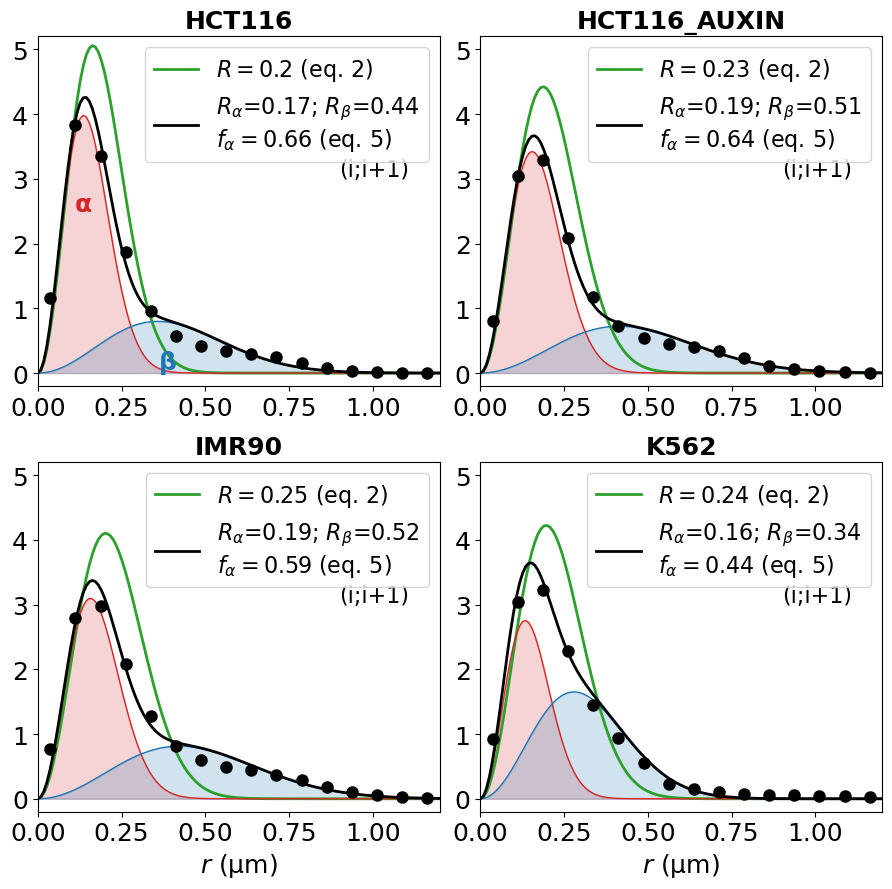

In [17]:
n = 1  # Set the parameter 'n' for offset
nplots = [221, 222, 223, 224]  # Define subplot positions
StepParam = {}  # Initialize a dictionary to store parameters
fig = plt.figure(figsize=(9, 9))  # Create a new figure

# Iterate over different cell lines
for i, cell_line in enumerate(['HCT116', 'HCT116_AUXIN', 'IMR90', 'K562']):
    StepParam[cell_line] = {}  # Initialize a sub-dictionary for the current cell line

    zxys = RESULTS[cell_line]['zxys']  # Get the spatial data for the current cell line

    # Compute a histogram of pairwise distances
    hist, bins = CompleteHistogram(zxys, n=n)

    # Calculate bin centers
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # Fit a Gaussian distribution to the data
    param1, pcov = curve_fit(GAUSSIAN_DISTR, bin_centers, hist, bounds=([0], [2]))

    # Fit a weighted combination of two Gaussian distributions to the data
    param2, pcov = curve_fit(TWO_GAUSSIAN_DISTR, bin_centers, hist, bounds=([0, 0, 0], [1, 2, 1]))

    # Store the parameters in the StepParam dictionary
    StepParam[cell_line][1] = param1
    StepParam[cell_line][2] = param2

    rr = np.linspace(0, 1.8, 200)  # Create a range for plotting

    ax = fig.add_subplot(nplots[i])  # Add a subplot to the figure
    plt.title(f'{cell_line}', fontsize=18, fontweight='bold')  # Set the subplot title

    # Plot the Gaussian distribution with parameters
    plt.plot(rr, GAUSSIAN_DISTR(rr, *param1), c='tab:green', lw=2, label=r'$R=$' + str(np.round(param1[0], 2)) + ' (eq. 2)')

    # Fill the area under the weighted Gaussian distributions
    plt.fill_between(rr, param2[2] * GAUSSIAN_DISTR(rr, param2[0]), color='tab:red', alpha=0.2)
    plt.plot(rr, param2[2] * GAUSSIAN_DISTR(rr, param2[0]), color='tab:red', lw=1)
    plt.fill_between(rr, (1 - param2[2]) * GAUSSIAN_DISTR(rr, param2[1]), color='tab:blue', alpha=0.2)
    plt.plot(rr, (1 - param2[2]) * GAUSSIAN_DISTR(rr, param2[1]), color='tab:blue', lw=1)

    # Create a label for the weighted Gaussian distribution
    label = r'$R_\alpha$=' + str(np.round(param2[0], 2)) + r'; $R_\beta$=' + str(np.round(param2[1], 2)) + '\n' + r'$f_\alpha=$' + str(np.round(param2[2], 2)) + ' (eq. 5)'
    plt.plot(rr, TWO_GAUSSIAN_DISTR(rr, *param2), c='black', lw=2, label=label)

    plt.plot(bin_centers, hist, 'o', ms=6, mew=3, mec='black', c='black')  # Plot data points

    plt.xlim([0, 1.2])  # Set the x-axis limits
    plt.ylim([-0.2, 5.2])  # Set the y-axis limits
    plt.legend(loc='upper right', fontsize=16)  # Add a legend
    plt.text(0.75, 0.6, f'(i;i+{n})', transform=ax.transAxes, fontsize=16)  # Add text
    if nplots[i] in [221]:  # Customize the plot appearance
        plt.text(0.09, 0.5, r'$\mathbf{\alpha}$', transform=ax.transAxes, fontsize=18, color='tab:red')
        plt.text(0.3, 0.05, r'$\mathbf{\beta}$', transform=ax.transAxes, fontsize=18, color='tab:blue')
    plt.tick_params(labelsize=18)
    if nplots[i] in [223, 224]:
        plt.xlabel(r'$r$ (µm)', size=18)  # Set x-axis label

plt.tight_layout()  # Adjust subplot layout
# plt.savefig


# 3.4.3 Comparison of Topological Phases and Radius of Gyration

In [18]:
def RadiusOfGyration(zxy, n, interpolate=False):
    """
    Calculate the Radius of Gyration for a given 3D coordinate sequence.

    Parameters:
    zxy (array-like): 3D coordinates (z, x, y) of particles over time.
    n (int): Window size for calculating the Radius of Gyration.
    interpolate (bool): If True, interpolate zxy data.

    Returns:
    ps (array): Time indices associated with calculated Rg values.
    rg (array): Calculated Radii of Gyration over the chromosome region.
    """
    if interpolate:
        zxy = interpolate_zxy(zxy)  # Optionally interpolate zxy data
    
    ps = []  # List to store time indices
    rg = []  # List to store Radii of Gyration
    i = 0
    while i + n < len(zxy):
        rg.append(np.sqrt(np.sum(np.var(zxy[i:i+n], axis=0))))  # Calculate Rg for the window
        i += 1
        ps.append((2 * i + n - 1) / 2)  # Store the time index
    
    return np.array(ps), np.array(rg)  # Convert lists to numpy arrays


def RadiusOfGyration_cell_line(zxys, n, interpolate=False):
    """
    Calculate the Radius of Gyration for a list of cell line coordinates.

    Parameters:
    zxys (list): List of 3D coordinate sequences for multiple cells.
    n (int): Window size for calculating the Radius of Gyration.
    interpolate (bool): If True, interpolate zxy data.

    Returns:
    ps (array): Time indices associated with calculated Rg values.
    Rg (array): Calculated Radii of Gyration over the chromosome region for all cells.
    """
    ncells = len(zxys)  # Get the number of cells
    Rg = []  # List to store Rg values for all cells

    for c in range(ncells):
        zxy = zxys[c]  # Get the zxy coordinates for the current cell
        ps, rg = RadiusOfGyration(zxy, n=n, interpolate=interpolate)  # Calculate Rg for the cell
        Rg.append(rg)  # Store the Rg values for the cell
    
    return ps, np.array(Rg)  # Convert lists to numpy arrays


## 3.4.3.1 HCT116 cell line (+/-) Auxin

595


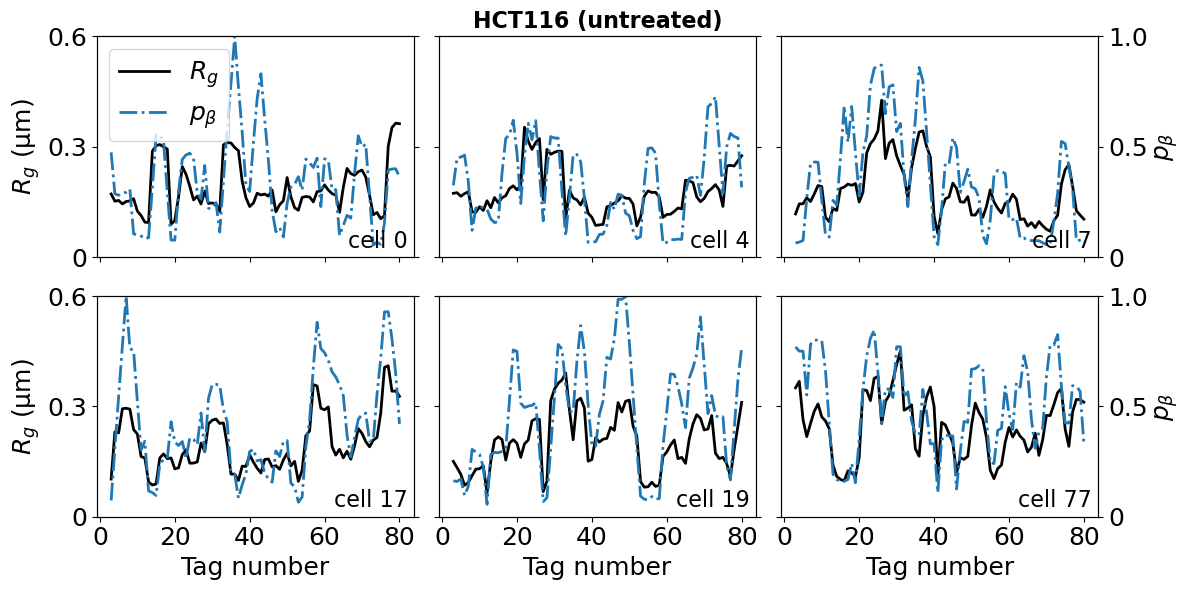

9


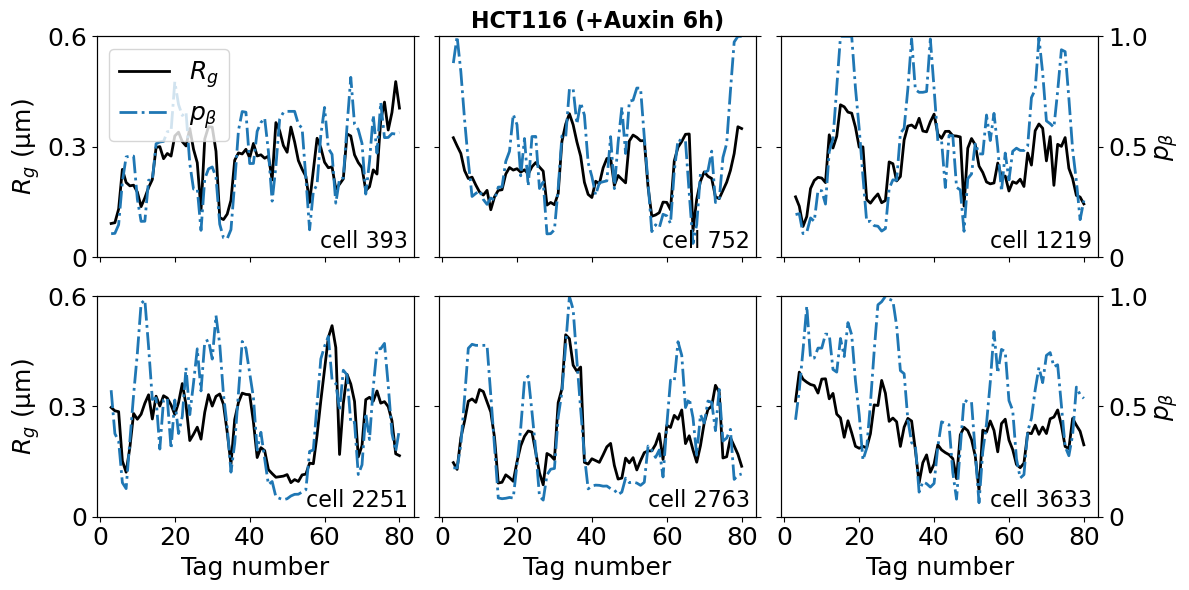

In [19]:
for cl, cell_line in enumerate(['HCT116', 'HCT116_AUXIN']):
    zxys = RESULTS[cell_line]['zxys']  # Get 3D coordinates for the cell line
    CELLS, zxys = NonNanPaths(zxys)  # Remove paths with NaN values
    ps, Rg = RadiusOfGyration_cell_line(zxys, 5, interpolate=False)  # Calculate Radius of Gyration
    cm = ClusterMap(zxys, interpolate=False)  # Create a cluster map
    ccm = CoarseClusterMap(cm, n=4)  # Create a coarse cluster map
    print(len(CELLS))

    cells = np.array([c for c in range(len(zxys)) if not True in np.isnan(zxys[c])], dtype=int)  # Filter non-NaN paths

    fig = plt.figure(figsize=(12, 6))
    nplots = [231, 232, 233, 234, 235, 236]
    ylims = [[0.05, 0.45], [0.05, 0.55]]

    for i, c in enumerate(cells[:6]):
        ax = fig.add_subplot(nplots[i])
        ax.plot(ps, Rg[c], c='black', label='$R_g$', lw=2)
        ax1 = ax.twinx()
        ax1.plot([], [], c='black', label='$R_g$', lw=2)
        ax1.plot(ps, ccm[c], '-.', c='tab:blue', label=r'$p_\beta$', lw=2)
        ax.set_ylim(ylims[cl])
        ax1.set_ylim([-0.05, 1.05])
        ax.set_xticks([0, 20, 40, 60, 80], [])
        ax.set_yticks([0, 0.3, 0.6], [])
        ax1.set_yticks([0, 0.5, 1.0], [])

        if nplots[i] in [234, 235, 236]:
            ax.set_xlabel('Tag number', fontsize=18)
            ax.set_xticks([0, 20, 40, 60, 80], [0, 20, 40, 60, 80], fontsize=18)
        if nplots[i] in [231, 234]:
            ax.set_ylabel('$R_g$ (µm)', fontsize=18)
            ax.set_yticks([0, 0.3, 0.6], [0, 0.3, 0.6], fontsize=18)
        if nplots[i] in [233, 236]:
            ax1.set_ylabel(r'$p_\beta$', fontsize=18)
            ax1.set_yticks([0, 0.5, 1.0], [0, 0.5, 1.0], fontsize=18)
        if nplots[i] in [232]:
            name = RESULTS[cell_line]['name']
            plt.title(f'{name}', fontsize=16, fontweight='bold')
        if nplots[i] == 231:
            ax1.legend(loc='upper left', fontsize=18)
        ax1.set_ylim([0, 1])
        plt.tick_params(labelsize=18)
        plt.text(0.98, 0.02, f'cell {CELLS[c]}', transform=ax.transAxes, fontsize=16, ha='right', va='bottom')
    plt.tight_layout()
#     plt.savefig(f'{name}_Rg_pb.png', facecolor='white', dpi=500)
    plt.show()


## 3.4.3.2 IMR90 cell line

119


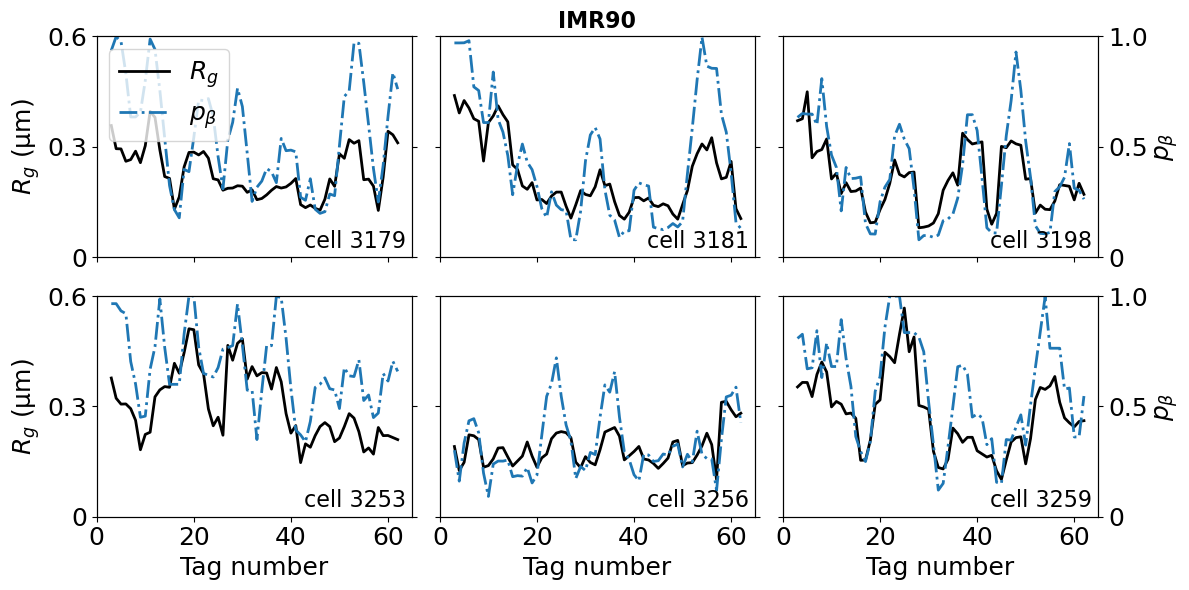

In [20]:
for cl,cell_line in enumerate(['IMR90']):
    zxys=RESULTS[cell_line]['zxys']
    CELLS,zxys=NonNanPaths(zxys)
    ps,Rg=RadiusOfGyration_cell_line(zxys,5,interpolate=False)
    cm=ClusterMap(zxys,interpolate=False)
    ccm=CoarseClusterMap(cm,n=4)
    print(len(CELLS))

    cells=np.array([c for c in range(len(zxys)) if not True in np.isnan(zxys[c])],dtype=int)
    fig=plt.figure(figsize=(12,6))
    nplots=[231,232,233,234,235,236]
    ylims=[[0.05,0.45],[0.05,0.55]]
    for i,c in enumerate(cells[:6]):
        ax=fig.add_subplot(nplots[i])
        ax.plot(ps,Rg[c],c='black',label='$R_g$',lw=2)
        ax1=ax.twinx()
        ax1.plot([],[],c='black',label='$R_g$',lw=2)
        ax1.plot(ps,ccm[c],'-.',c='tab:blue',label=r'$p_\beta$',lw=2)
        ax.set_ylim(ylims[cl])
        ax1.set_ylim([-0.05,1.05])
        ax.set_xticks([0,20,40,60],[])
        ax.set_yticks([0,0.3,0.6],[])
        ax1.set_yticks([0,0.5,1.0],[])
        if nplots[i] in [234,235,236]:
            ax.set_xlabel('Tag number',fontsize=18)
            ax.set_xticks([0,20,40,60],[0,20,40,60],fontsize=18)
        if nplots[i] in [231,234]:
            ax.set_ylabel('$R_g$ (µm)',fontsize=18)
            ax.set_yticks([0,0.3,0.6],[0,0.3,0.6],fontsize=18)
        if nplots[i] in [233,236]:
            ax1.set_ylabel(r'$p_\beta$',fontsize=18)
            ax1.set_yticks([0,0.5,1.0],[0,0.5,1.0],fontsize=18)
        if nplots[i] in [232]:
            name=RESULTS[cell_line]['name']
            plt.title(f'{name}',fontsize=16,fontweight='bold')
        if nplots[i]==231:
            ax1.legend(loc='upper left',fontsize=18)
        ax1.set_ylim([0,1])
        plt.tick_params(labelsize=18)
        plt.text(0.98,0.02,f'cell {CELLS[c]}',transform=ax.transAxes,fontsize=16,ha='right',va='bottom')
    plt.tight_layout()
#     plt.savefig(f'{name}_Rg_pb.png',facecolor='white',dpi=500)
    plt.show()

## 3.4.3.3 K562 cell line

68


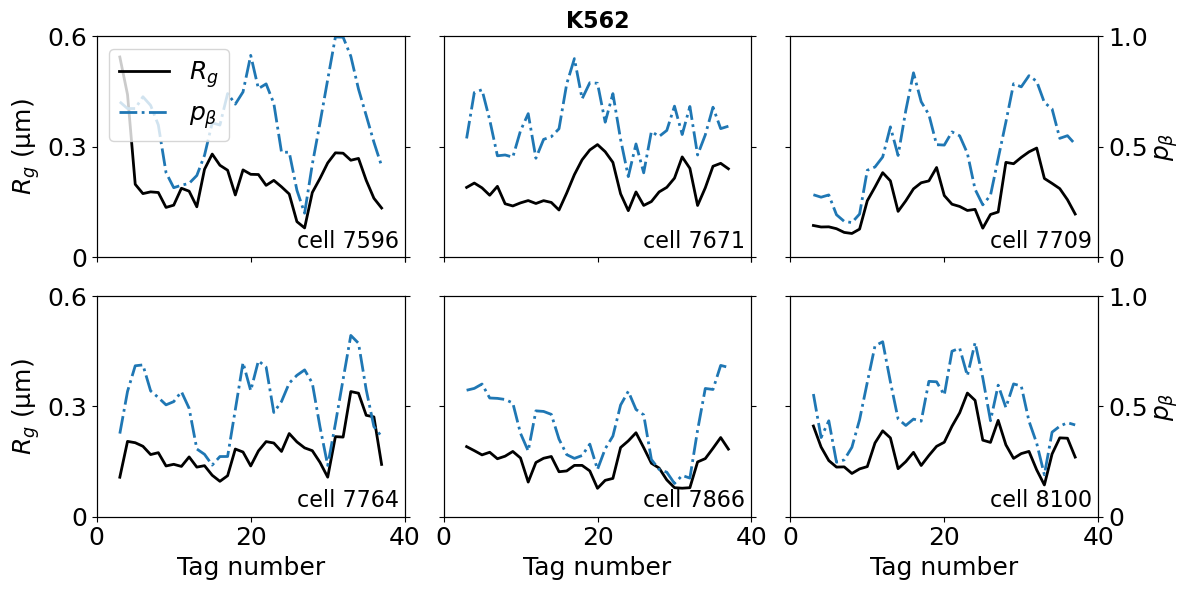

In [21]:
for cl,cell_line in enumerate(['K562']):
    zxys=RESULTS[cell_line]['zxys'][:,:40]
    CELLS,zxys=NonNanPaths(zxys)
    ps,Rg=RadiusOfGyration_cell_line(zxys,5,interpolate=False)
    cm=ClusterMap(zxys,interpolate=False)
    ccm=CoarseClusterMap(cm,n=4)
    print(len(CELLS))

    cells=np.array([c for c in range(len(zxys)) if not True in np.isnan(zxys[c])],dtype=int)
    fig=plt.figure(figsize=(12,6))
    nplots=[231,232,233,234,235,236]
    ylims=[[0.05,0.45],[0.05,0.55]]
    for i,c in enumerate(cells[:6]):
        ax=fig.add_subplot(nplots[i])
        ax.plot(ps,Rg[c],c='black',label='$R_g$',lw=2)
        ax1=ax.twinx()
        ax1.plot([],[],c='black',label='$R_g$',lw=2)
        ax1.plot(ps,ccm[c],'-.',c='tab:blue',label=r'$p_\beta$',lw=2)
        ax.set_ylim(ylims[cl])
        ax1.set_ylim([-0.05,1.05])
        ax.set_xticks([0,20,40,40],[])
        ax.set_yticks([0,0.3,0.6],[])
        ax1.set_yticks([0,0.5,1.0],[])
        if nplots[i] in [234,235,236]:
            ax.set_xlabel('Tag number',fontsize=18)
            ax.set_xticks([0,20,40],[0,20,40],fontsize=18)
        if nplots[i] in [231,234]:
            ax.set_ylabel('$R_g$ (µm)',fontsize=18)
            ax.set_yticks([0,0.3,0.6],[0,0.3,0.6],fontsize=18)
        if nplots[i] in [233,236]:
            ax1.set_ylabel(r'$p_\beta$',fontsize=18)
            ax1.set_yticks([0,0.5,1.0],[0,0.5,1.0],fontsize=18)
        if nplots[i] in [232]:
            name=RESULTS[cell_line]['name']
            plt.title(f'{name}',fontsize=16,fontweight='bold')
        if nplots[i]==231:
            ax1.legend(loc='upper left',fontsize=18)
        ax1.set_ylim([0,1])
        plt.tick_params(labelsize=18)
        plt.text(0.98,0.02,f'cell {CELLS[c]}',transform=ax.transAxes,fontsize=16,ha='right',va='bottom')
    plt.tight_layout()
#     plt.savefig(f'{name}_Rg_pb.png',facecolor='white',dpi=500)
    plt.show()

In [22]:
for cell_line in ['HCT116','HCT116_AUXIN','IMR90','K562']:
    zxys=RESULTS[cell_line]['zxys']
    cm=ClusterMap(zxys)
    print('fa',1-np.nanmean(cm))

fa 0.6742302243545846
fa 0.654734566356649
fa 0.6029824721180892


/var/folders/tq/dgzmpwks2bd9glbd8wtm_99m0000gp/T/ipykernel_7840/3809082737.py:47: RuntimeWarning: invalid value encountered in divide
  clts.append((1-param[2])*GAUSSIAN_DISTR(np.diagonal(dm[c],offset=1),param[1])/TWO_GAUSSIAN_DISTR(np.diagonal(dm[c],offset=1),*param))


fa 0.44631405611091546


# 3.5 Single Cell Distributions

(11631, 83, 83)


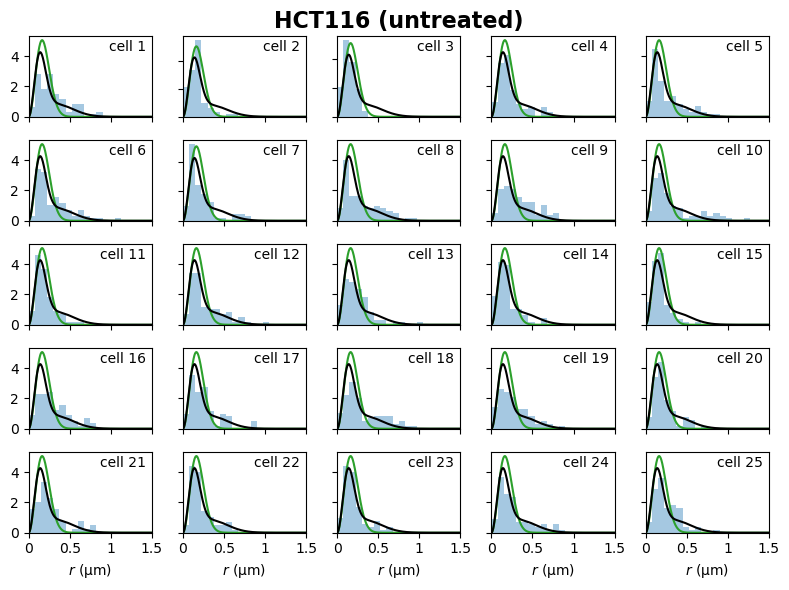

(9526, 83, 83)


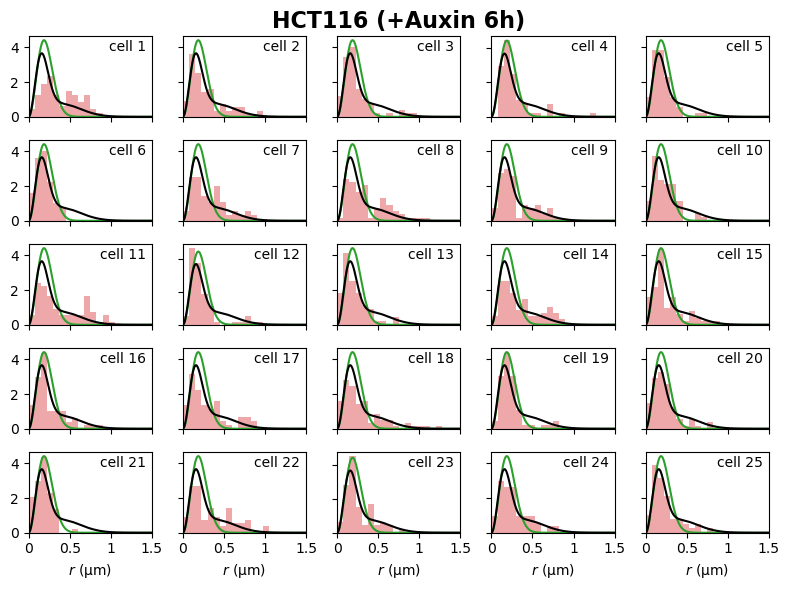

(4871, 65, 65)


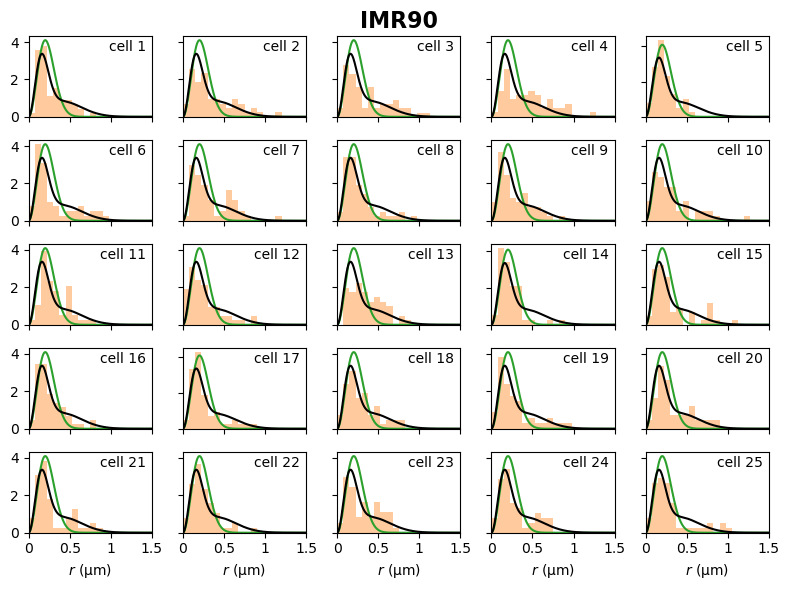

(13997, 65, 65)


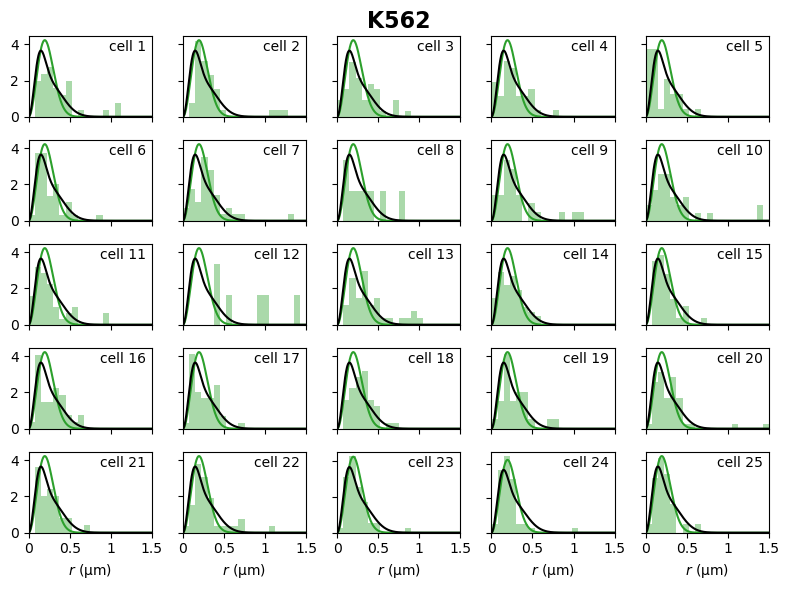

In [23]:
# Define the bins for the histogram
bins = np.linspace(0, 1.8, 25)

# Iterate over cell lines: HCT116, HCT116_AUXIN, IMR90, K562
for cell_line in ['HCT116', 'HCT116_AUXIN', 'IMR90', 'K562']:
    # Get the distance matrix and color information for the current cell line
    dm = RESULTS[cell_line]['distmat']
    color = RESULTS[cell_line]['color']
    print(np.shape(dm))
    ncells = len(dm)  # Get the number of cells

    # Create a new figure
    fig = plt.figure(figsize=(8, 6))

    # Iterate over subplots (cells)
    for c in np.arange(1, 26):
        dat = np.diagonal(dm[c], offset=1)  # Extract the diagonal data
        ax = fig.add_subplot(5, 5, c)  # Create a subplot for each cell

        # Plot a histogram of the data
        ax.hist(dat, bins=bins, density=True, color=color, alpha=0.4)

        # Define a range for x-axis
        rr = np.linspace(0, 1.8, 500)

        # Plot Gaussian distribution based on StepParam
        ax.plot(rr, GAUSSIAN_DISTR(rr, *StepParam[cell_line][1]), c='tab:green')
        ax.plot(rr, TWO_GAUSSIAN_DISTR(rr, *StepParam[cell_line][2]), c='black')

        # Add text for cell label
        ax.text(0.95, 0.95, f'cell {c}', transform=ax.transAxes, va='top', ha='right')

        # Set axis limits and ticks
        ax.set_xlim(0, 1.5)
        ax.set_xticks([0, 0.5, 1, 1.5])
        ax.set_xticklabels([])
        ax.set_yticks([0, 2, 4])
        ax.set_yticklabels([])

        if c % 5 == 1:
            ax.set_yticklabels([0, 2, 4], size=10)

        if c > 20:
            ax.set_xticklabels([0, 0.5, 1, 1.5], size=10)
            ax.set_xlabel(r'$r$ (µm)')

        if c == 3:
            ax.set_title(RESULTS[cell_line]['name'], fontsize=16, fontweight='bold')

    # Adjust the layout of the subplots
    plt.tight_layout()
    
    # Show the figure for the current cell line
    plt.show()


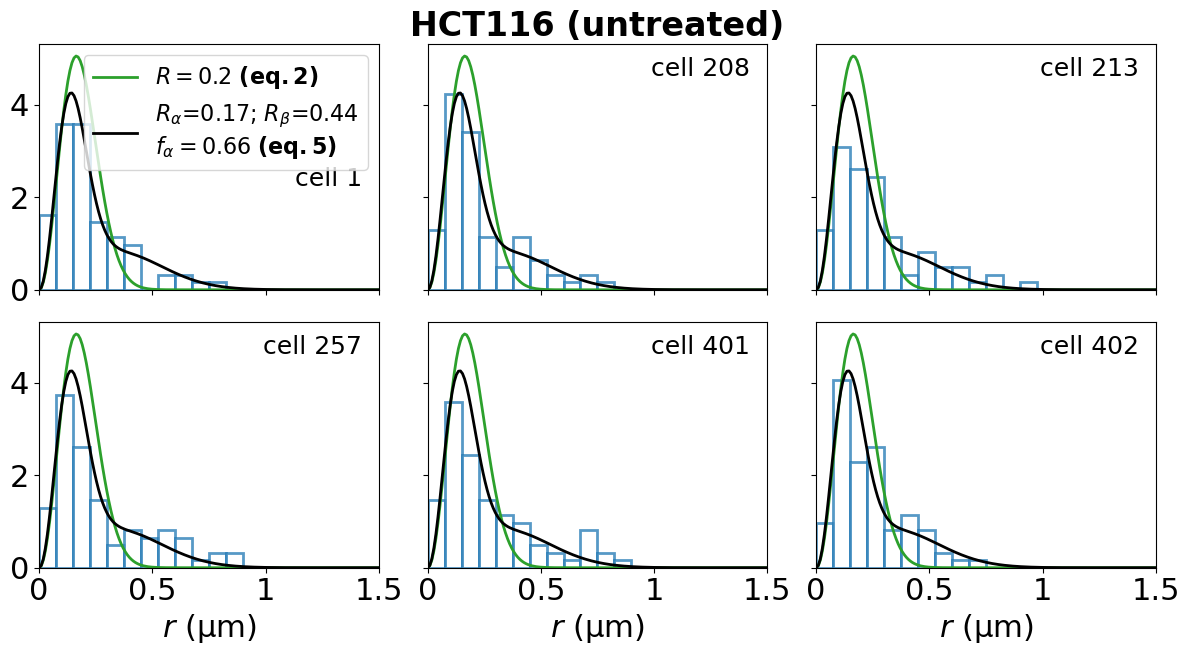

In [24]:
# Define the bins for the histogram
bins = np.linspace(0, 1.8, 25)

# Iterate over the specified cell line(s) (e.g., 'HCT116')
for cell_line in ['HCT116']:
    # Create a new figure for the cell line
    fig = plt.figure(figsize=(12, 6.65))

    # Get the cell coordinates and remove paths with NaN values
    zxys = RESULTS[cell_line]['zxys']
    CELLS, zxys = NonNanPaths(zxys)

    # Calculate the distance matrix for all cells in the cell line
    dm = np.array(list(map(squareform, map(pdist, zxys)))) 
    

    # Iterate over specific cells (0, 11, 14, 19, 22, 23) for visualization
    for i, c in enumerate([0, 11, 14, 19, 22, 23]):
        ax = fig.add_subplot(2, 3, i + 1)  # Create a subplot for each cell

        dat = np.diagonal(dm[c], offset=1)  # Extract diagonal data

        # Plot a histogram of the data
        ax.hist(dat, bins=bins, density=True, edgecolor='tab:blue', alpha=0.75, lw=2, color='white')

        rr = np.linspace(0, 1.8, 200)  # Define a range for x-axis

        # Retrieve parameters for Gaussian distributions from StepParam
        param1 = StepParam[cell_line][1]
        param2 = StepParam[cell_line][2]

        # Define the label for the legend
        label = r'$R_\alpha$=' + str(np.round(param2[0], 2)) + r'; $R_\beta$=' + str(np.round(param2[1], 2)) + '\n' + r'$f_\alpha=$' + str(
            np.round(param2[2], 2)) + r' $\mathbf{(eq. 5)}$'

        # Plot Gaussian and Two-Gaussian distributions
        ax.plot(rr, GAUSSIAN_DISTR(rr, *param1), c='tab:green', lw=2, label=r'$R=$' + str(np.round(param1[0], 2)) + r' $\mathbf{(eq. 2)}$')
        ax.plot(rr, TWO_GAUSSIAN_DISTR(rr, *param2), c='black', lw=2, label=label)

        # Set axis limits and ticks
        ax.set_xlim(0, 1.5)
        ax.set_xticks([0, 0.5, 1, 1.5])
        ax.set_xticklabels([])
        ax.set_yticks([0, 2, 4])
        ax.set_yticklabels([])

        # Configure y-axis ticks and labels based on the subplot
        if i in [0, 3]:
            ax.set_yticklabels([0, 2, 4], size=22)
        if i > 2:
            ax.set_xticklabels([0, 0.5, 1, 1.5], size=22)
            ax.set_xlabel(r'$r$ (µm)', size=22)

        # Set the title of the subplot
        if i == 1:
            name = RESULTS[cell_line]['name']
            plt.title(f'{name}', fontsize=24, fontweight='bold')

        # Add a legend for the first subplot and label the cell
        if i == 0:
            plt.legend(fontsize=16)
            ax.text(0.95, 0.5, f'cell {CELLS[c] + 1}', transform=ax.transAxes, va='top', ha='right', fontsize=18)
        else:
            ax.text(0.95, 0.95, f'cell {CELLS[c] + 1}', transform=ax.transAxes, va='top', ha='right', fontsize=18)

    # Adjust the layout of the subplots
    plt.tight_layout()

    # Show the figure for the current cell line
    plt.show()


# 3.6 Single cells' distributions vs (i,i+1) distribution

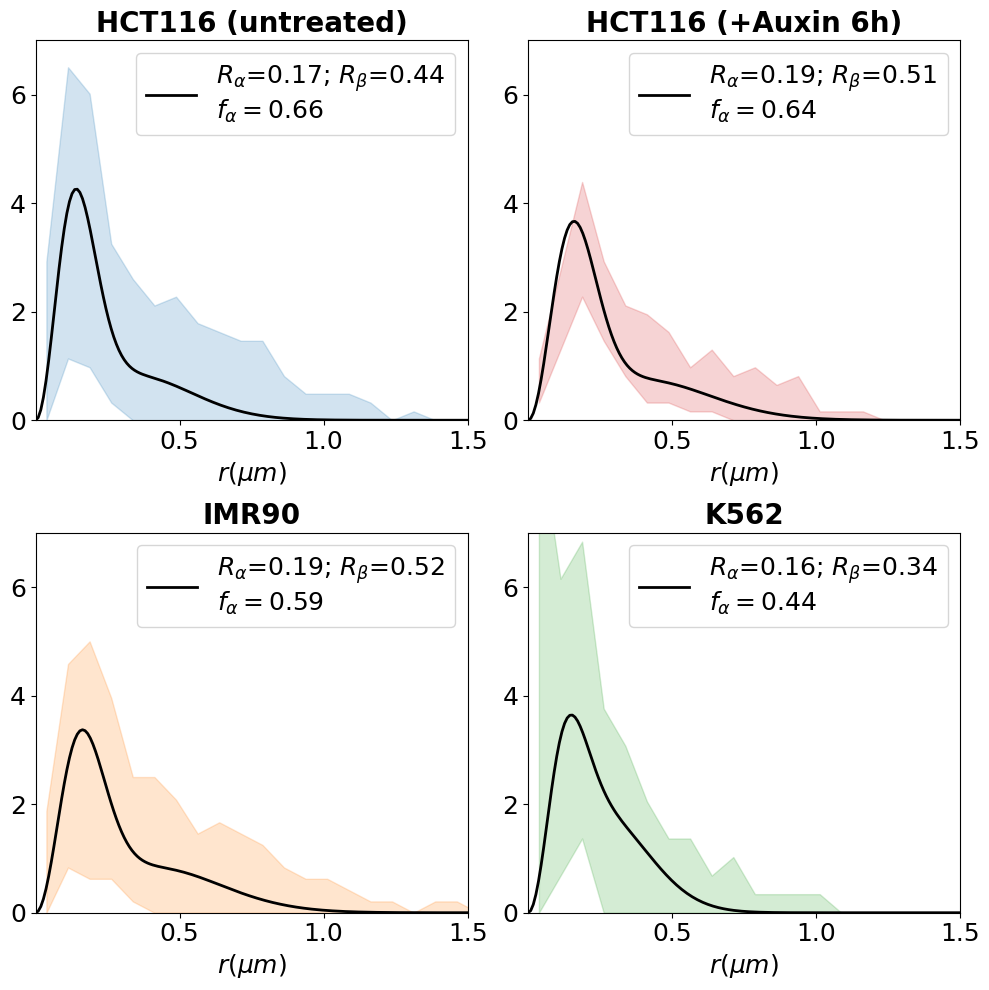

In [25]:
# Here we plot all the distance distributions of single cells of each cell-line and compare them with a one-step distribution

# # Define the number of curves to be plotted
# num_curves = len(dm)

# # Create a color cycle for the curves
# colors = [cmap(i / num_curves) for i in range(num_curves)]

# Define the bins for the histogram
bins = np.linspace(0, 1.8, 25)

# Create a single figure with subplots for each cell line
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

# Iterate over specific cell lines ('HCT116', 'HCT116_AUXIN', 'IMR90', 'K562')
for idx, cell_line in enumerate(['HCT116', 'HCT116_AUXIN', 'IMR90', 'K562']):
    # Retrieve cell coordinates and apply conditional slicing for 'K562'
    zxys = RESULTS[cell_line]['zxys']
    if cell_line == 'K562':
        zxys = RESULTS[cell_line]['zxys'][:, :40]
    color = RESULTS[cell_line]['color']

    # Extract paths without NaN values
    CELLS, zxys = NonNanPaths(zxys)

    # Calculate the distance matrix for the cell line
    dm = np.array(list(map(squareform, map(pdist, zxys))))

    # Create an array to store the smoothed curves for all cells
    smoothed_curves = []

    # Iterate over all cells in the cell line
    for c in np.arange(0, len(dm)):
        dat = np.diagonal(dm[c], offset=1)

        # Compute a histogram of the data with specified bins
        n, bins = np.histogram(dat, bins=bins, density=True)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        delta_bin = bins[1] - bins[0]
        n = [0] + n
        bin_centers = [0] + bin_centers
        smoothed_curve = np.interp(bin_centers, bin_centers, n)

        smoothed_curves.append(smoothed_curve)

        rr = np.linspace(0, 1.8, 200)
        param1 = StepParam[cell_line][1]
        param2 = StepParam[cell_line][2]

    # Find the maximum and minimum values among all smoothed curves
    max_curve = np.max(smoothed_curves, axis=0)
    min_curve = np.min(smoothed_curves, axis=0)

    # Plot the filled area between the maximum and minimum curves
    axes[idx].fill_between(bin_centers, min_curve, max_curve, alpha=0.2, color=color)

    # Set the x and y limits for the subplot
    axes[idx].set_xlim(0, 1.5)
    axes[idx].set_ylim(0, 7)

    # Set x and y ticks and labels
    axes[idx].set_xticks([0.5, 1, 1.5])
    axes[idx].set_yticks([0, 2, 4, 6])
    axes[idx].set_xlabel(r"$r(\mu m)$", fontsize=18)

    # Create a label for the legend
    label = r'$R_\alpha$=' + str(np.round(param2[0], 2)) + r'; $R_\beta$=' + str(np.round(param2[1], 2)) + '\n' + r'$f_\alpha=$' + str(np.round(param2[2], 2))

    # Configure tick parameters
    axes[idx].tick_params(axis='x', which='both', labelleft=True, left=True, labelsize=18)
    axes[idx].tick_params(axis='y', which='both', labelleft=True, left=True, labelsize=18)

    # Plot the Two-Gaussian distribution
    axes[idx].plot(rr, TWO_GAUSSIAN_DISTR(rr, *StepParam[cell_line][2]), c='black', lw=2, label=label)
    
    # Add a legend
    axes[idx].legend(fontsize=18)
    
    # Set the title for the subplot
    name = RESULTS[cell_line]['name']
    axes[idx].set_title(f'{name}', fontsize=20, fontweight='bold')

# Adjust the layout of subplots
plt.tight_layout()

# Show the figure
plt.show()


/var/folders/tq/dgzmpwks2bd9glbd8wtm_99m0000gp/T/ipykernel_7840/3698776930.py:47: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/Loucif/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/Users/Loucif/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/var/folders/tq/dgzmpwks2bd9glbd8wtm_99m0000gp/T/ipykernel_7840/3698776930.py:50: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/Loucif/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


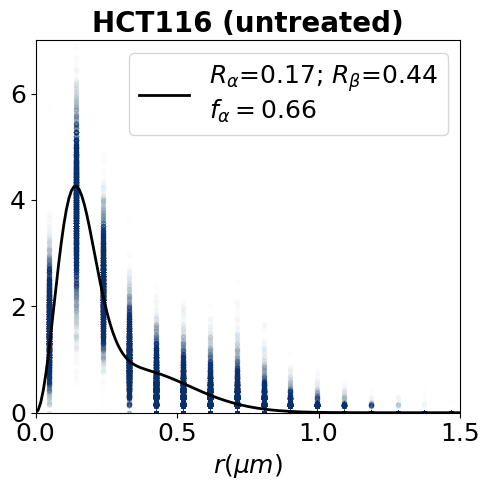

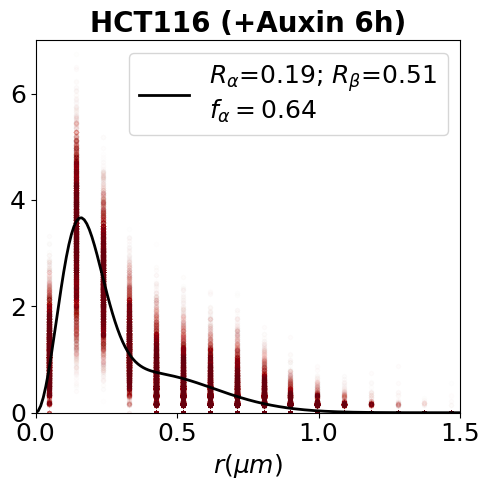

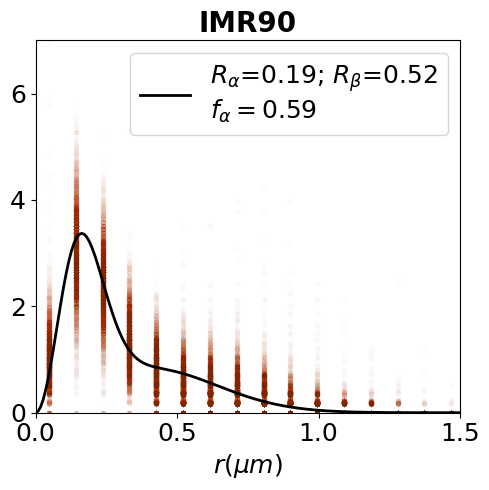

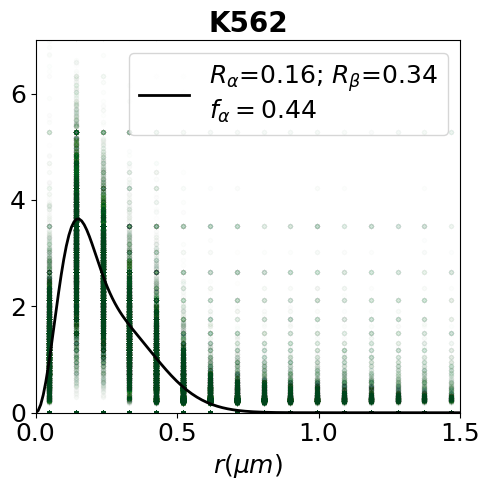

In [26]:
# Define a colormap
cmap = [plt.get_cmap('Blues'), plt.get_cmap('Reds'), plt.get_cmap('Oranges'), plt.get_cmap('Greens')]

nbins = 20
bins = np.linspace(0, 1.8, nbins)
for cl, cell_line in enumerate(['HCT116', 'HCT116_AUXIN', 'IMR90', 'K562']):
    fig = plt.figure(figsize=(5, 5))
    zxys = RESULTS[cell_line]['zxys']
    if cell_line == 'K562':
        zxys = RESULTS[cell_line]['zxys'][:, :40]
    CELLS, zxys = NonNanPaths(zxys)
    dm = RESULTS[cell_line]['distmat']

    # Define the number of curves to be plotted
    num_curves = len(dm)

    # Create a color cycle for the curves
    colors = [cmap[cl](i / num_curves) for i in range(num_curves)]

    for c in np.arange(0, len(dm)):
        dat = np.diagonal(dm[c], offset=1)
        n, bins = np.histogram(dat, bins=bins, density=True)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        delta_bin = bins[1] - bins[0]
        n = [0] + n
        bin_centers = [0] + bin_centers
        smoothed_curve = np.interp(bin_centers, bin_centers, n)

        plt.plot(bin_centers, smoothed_curve, 'o', markersize=3, color=colors[c], alpha=0.01)
        rr = np.linspace(0, 1.8, 200)
        param1 = StepParam[cell_line][1]
        param2 = StepParam[cell_line][2]

    plt.xlim(0, 1.5)
    plt.ylim(0, 7)
    plt.xticks([0, 0.5, 1, 1.5])
    plt.yticks([0, 2, 4, 6])
    plt.xlabel(r"$r(\mu m)$", fontsize=18)
    label = r'$R_\alpha$=' + str(np.round(param2[0], 2)) + r'; $R_\beta$=' + str(np.round(param2[1], 2)) + '\n' + r'$f_\alpha=$' + str(np.round(param2[2], 2))

    plt.tick_params(axis='x', which='both', labelleft=True, left=True, labelsize=18)
    plt.tick_params(axis='y', which='both', labelleft=True, left=True, labelsize=18)
    plt.plot(rr, TWO_GAUSSIAN_DISTR(rr, *StepParam[cell_line][2]), c='black', lw=2, label=label)
    plt.legend(fontsize=18, ncol=1)
    name = RESULTS[cell_line]['name']
    plt.title(f'{name}', fontsize=20, fontweight='bold')
    plt.tight_layout()

# Adjust the layout of subplots
plt.tight_layout()

# Show the figure
plt.show()
